# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos Agonistas de la Hormona GLP-1**

### Avance 4: Modelos alternativos

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dra. Eduviges Ludivina Facundo Flores  – Profesor Tutor

### **Asesores**
- Dr. Juan Arturo Nolazco Flores
- Dr. Carlos Alberto Brizuela Rodríguez

#### **Miembros del equipo:**
- Cesar Ivan Herrera Martinez A01796392  
- Juan Antonio Cruz Acosta A01795375 
- Julio Baltazar Colín A01794476 

# Modelos Alternativos
Generación de Nuevas secuencias Peptídicas Agonistas de GLP-1 mediante Modelos de Lenguaje y Evaluación In Silico de su Actividad Biológica

## Introducción

En el avance anterior, se desarrolló y evaluó un conjunto de modelos predictivos con el fin de estimar la actividad pEC50 a partir de descriptores moleculares, con lo cual se cumplió el objetivo de la Actividad 4 como está definida. Este modelo seleccionado constituyó la base del pipeline de predicción, sobre el cual se construye la presente etapa del proyecto. De acuerdo a la naturaleza de este proyecto el propósito de este entregable es extender el uso de la inteligencia artificial desde la predicción hacia la generación de nuevas secuencias peptídicas con potencial actividad agonista de GLP-1, se utilizara el modelo ProtXLNet (Elnaggar et al., 2021) para la generación de nuevas secuencias y posteriormente se evaluaran dichas secuencias.

Para cumplir con este propósito, se incorporaran modelos de lenguaje biomolecular, como PeptideBERT, que emplean arquitecturas transformer para aprender representaciones profundas de secuencias de aminoácidos. Estos modelos, entrenados de manera auto-supervisada, pueden capturar patrones evolutivos y estructurales que permiten predecir propiedades fisicoquímicas relevantes y sugerir variaciones plausibles de péptidos con características terapéuticas (Elnaggar et al., 2022; Madani et al., 2023). Su aplicación en esta etapa busca aprovechar dichas capacidades para explorar el espacio peptídico y proponer candidatos generados computacionalmente.

Se analizarán propiedades críticas que determinan la viabilidad farmacológica de los péptidos: hemólisis, solubilidad y no adherencia (non-fouling). Cada una de estas propiedades incide directamente en la seguridad, estabilidad y biodisponibilidad de los compuestos. La hemólisis se vincula con la toxicidad celular y la disrupción de membranas (Grasso et al., 2021), la solubilidad afecta la absorción y formulación de los péptidos (Li et al., 2022), y la no adherencia permite identificar secuencias menos propensas a interacciones no específicas (White et al., 2019).

El Avance 4 se plantea, por tanto, como una etapa de exploración computacional orientada a la aplicación de modelos generativos y predictivos en la búsqueda de nuevos péptidos agonistas de GLP-1. El trabajo integra el aprendizaje profundo con la biología computacional para establecer una metodología reproducible que favorezca el descubrimiento acelerado de fármacos y fortalezca la relación entre la inteligencia artificial y las ciencias biomédicas contemporáneas. En este concepto se ejecutaran los tres modelos de peptideBERT en una funcion recursiva y se concatenaran los resultados en un dataframe para un mejor manejo

## Generación de Nuevas secuencias Peptídicas Agonistas de GLP-1 mediante Modelos de Lenguaje

### Carga de los datos base para la generación de nuevas secuencias

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from pathlib import Path
# iFeature cambia la configuración de matplotlib, por lo que se debe volver a activar
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Machine Learning y Transformers
from sklearn.model_selection import train_test_split
from transformers import (
    XLNetLMHeadModel,
    XLNetTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import Dataset

# ruta del directorio del notebook actual
notebook_dir = Path.cwd()
directorio_base = Path.cwd().parent
sys.path.append(str(directorio_base))

from src.plotting import plot_pca_3d, clasificar_y_graficar_cuantiles



In [2]:
# Establecer la ruta los archivos de datos

directorio_datos = Path(directorio_base / "data")
directorio_modelos = Path(directorio_base / "models")
directorio_modelos_automl= Path(directorio_modelos / "pycaret")
raw_data_dir = directorio_datos / "raw"
processed_data_dir = directorio_datos / "processed"

#ruta a los modelos automl
ruta_mejor_modelo_final = directorio_modelos_automl / "modelos_GLP1_no_pca" /"mejor_modelo_final"
# Ruta modelos generativos
ruta_modelo_protxlnet = directorio_modelos / "prot_xlnet_finetuned"

# Datos con actividad conocida
ruta_125_ec50 = processed_data_dir / "descriptores_125.csv"

# Datos con actividad predicha
ruta_predicciones_glp1 = processed_data_dir / "predicciones_glp1.csv"

# Datos sin actividad conocida
ruta_peptidos_eval = processed_data_dir / "descriptores_cdhit.csv"

# directorio para nuevas secuencias 
directorio_nuevas_secuencias = Path(processed_data_dir/ "secuencias_nuevas")
os.makedirs(directorio_nuevas_secuencias, exist_ok=True)

# directorio modelos peptide Bert
directorio_modelos_peptidebert = directorio_modelos / "peptideBert"


In [3]:
# cargar datos procesados
df_125_conocidos = pd.read_csv(ruta_125_ec50)
df_125_conocidos.set_index('ID', inplace=True)
df_125_conocidos.columns = df_125_conocidos.columns.str.replace('.', '_', regex=False)
df_125_conocidos['pEC50'] = -np.log10(df_125_conocidos["EC50_T2"] * 1e-12)

df_glp1 = pd.read_csv(ruta_peptidos_eval)
df_glp1.set_index('ID', inplace=True)
df_glp1.columns = df_glp1.columns.str.replace('.', '_', regex=False)

In [4]:
# visualizar los datos conocidos
df_125_conocidos.head()

AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G     AAC_H  \
ID                                                                            
seq_pep1  0.033333    0.0  0.100000  0.100000  0.066667  0.066667  0.033333   
seq_pep2  0.033333    0.0  0.100000  0.100000  0.066667  0.066667  0.033333   
seq_pep3  0.034483    0.0  0.103448  0.068966  0.068966  0.034483  0.034483   
seq_pep4  0.055556    0.0  0.083333  0.027778  0.055556  0.166667  0.027778   
seq_pep5  0.066667    0.0  0.100000  0.066667  0.066667  0.066667  0.033333   

          AAC_I     AAC_K     AAC_L  ...  NMBroto_BEGF750103_lag1  \
ID                                   ...                            
seq_pep1    0.0  0.033333  0.066667  ...                -0.027980   
seq_pep2    0.0  0.033333  0.066667  ...                 0.000910   
seq_pep3    0.0  0.034483  0.068966  ...                -0.004817   
seq_pep4    0.0  0.027778  0.055556  ...                 0.225090   
seq_pep5    0.0  0.033333  0.066667  ...                 0.088858   

          NMBroto_BEGF750103_lag2  NMBroto_BEGF750103_lag3  \
ID                                                           
seq_pep1                -0.182783                 0.054222   
seq_pep2                -0.316149                 0.170202   
seq_pep3                -0.250582                 0.181550   
seq_pep4                -0.097965                 0.052838   
seq_pep5                -0.190213                 0.020097   

          NMBroto_BHAR880101_lag1  NMBroto_BHAR880101_lag2  \
ID                                                           
seq_pep1                 0.190428                -0.142437   
seq_pep2                 0.157133                -0.144228   
seq_pep3                 0.098041                -0.203722   
seq_pep4                 0.377701                 0.150231   
seq_pep5                 0.069381                -0.184796   

          NMBroto_BHAR880101_lag3                              sequence  \
ID                                                                        
seq_pep1                 0.090372        HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE   
seq_pep2                 0.115217        HSQGTFTSDYSKYLDSRRAEDFVQWLENGE   
seq_pep3                 0.127012         HSQGTFTSDYSKYLDSRRAEDFVQWLENT   
seq_pep4                 0.286987  HSQGTFTSDYSKYLDSRRAEDFVQWLVAGGSGSGSG   
seq_pep5                 0.222087        HSQGTFTSDYSKYLDSRRAQDFVQWLEAEG   

          EC50_T2  EC50_LOG_T2      pEC50  
ID                                         
seq_pep1   563.00        -9.25   9.249492  
seq_pep2   552.00        -9.26   9.258061  
seq_pep3   252.00        -9.60   9.598599  
seq_pep4     6.03       -11.22  11.219683  
seq_pep5   238.00        -9.62   9.623423  

[5 rows x 1294 columns]

In [5]:
# visualizar los datos a predecir
df_glp1.head()

AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
ID                                                                          
AF-A0A060VXS0-F1  0.100000    0.0  0.066667  0.066667  0.033333  0.066667   
AF-A0A060VY52-F1  0.100000    0.0  0.066667  0.066667  0.033333  0.066667   
AF-A0A060WDT4-F1  0.100000    0.0  0.133333  0.000000  0.033333  0.066667   
AF-A0A087VEU7-F1  0.133333    0.0  0.033333  0.100000  0.033333  0.100000   
AF-A0A087XPV4-F1  0.100000    0.0  0.133333  0.000000  0.066667  0.066667   

                     AAC_H     AAC_I     AAC_K     AAC_L  ...  \
ID                                                        ...   
AF-A0A060VXS0-F1  0.033333  0.000000  0.066667  0.066667  ...   
AF-A0A060VY52-F1  0.033333  0.000000  0.066667  0.066667  ...   
AF-A0A060WDT4-F1  0.033333  0.000000  0.066667  0.100000  ...   
AF-A0A087VEU7-F1  0.033333  0.066667  0.033333  0.066667  ...   
AF-A0A087XPV4-F1  0.033333  0.033333  0.100000  0.066667  ...   

                  NMBroto_BEGF750102_lag1  NMBroto_BEGF750102_lag2  \
ID                                                                   
AF-A0A060VXS0-F1                 0.037142                -0.508484   
AF-A0A060VY52-F1                 0.037142                -0.508484   
AF-A0A060WDT4-F1                -0.029432                -0.341003   
AF-A0A087VEU7-F1                 0.068401                -0.469261   
AF-A0A087XPV4-F1                 0.094549                -0.460741   

                  NMBroto_BEGF750102_lag3  NMBroto_BEGF750103_lag1  \
ID                                                                   
AF-A0A060VXS0-F1                 0.112768                 0.224928   
AF-A0A060VY52-F1                 0.112768                 0.145803   
AF-A0A060WDT4-F1                 0.010969                -0.055908   
AF-A0A087VEU7-F1                -0.028003                 0.179833   
AF-A0A087XPV4-F1                 0.040947                 0.156853   

                  NMBroto_BEGF750103_lag2  NMBroto_BEGF750103_lag3  \
ID                                                                   
AF-A0A060VXS0-F1                -0.142711                 0.120597   
AF-A0A060VY52-F1                -0.195554                 0.086696   
AF-A0A060WDT4-F1                -0.413757                -0.005239   
AF-A0A087VEU7-F1                -0.232789                 0.257321   
AF-A0A087XPV4-F1                -0.296064                -0.234672   

                  NMBroto_BHAR880101_lag1  NMBroto_BHAR880101_lag2  \
ID                                                                   
AF-A0A060VXS0-F1                 0.099330                -0.372417   
AF-A0A060VY52-F1                 0.178218                -0.292699   
AF-A0A060WDT4-F1                 0.086834                -0.334601   
AF-A0A087VEU7-F1                 0.296206                -0.151547   
AF-A0A087XPV4-F1                 0.149114                -0.209235   

                  NMBroto_BHAR880101_lag3                        sequence  
ID                                                                         
AF-A0A060VXS0-F1                 0.041586  HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR  
AF-A0A060VY52-F1                 0.046946  HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR  
AF-A0A060WDT4-F1                -0.073197  HADGTYTSDVSTYLQDQAAKDFVSWLKSGL  
AF-A0A087VEU7-F1                -0.086574  HAEGTYTSDITSYLEGQAAKEFIAWLVNGR  
AF-A0A087XPV4-F1                -0.250359  HADGTFTSDVSSYLKDQAIKDFVAQLKSGQ  

[5 rows x 1291 columns]

### Predicción de actividad para los péptidos GLP-1

En este paso, se calcula la predicción de actividad pEC50 para los péptidos similares a GLP-1 con el fin de actualizar los datos utilizando el mejor modelo previamente entrenado.

Se carga dicho modelo para ejecutar la predicción sobre las nuevas secuencias generadas. Este modelo corresponde a un blending de algoritmos de regresión (Random Forest, XGBoost y LightGBM), entrenados a partir de descriptores moleculares derivados de las secuencias peptídicas.

Sus mejores hiperparámetros y desempeño fueron reportados en el Avance 3, donde se obtuvieron los siguientes resultados:
| Fold | MAE | MSE | RMSE | R2 | RMSLE | MAPE |
|---|---|---|---|---|---|---|
| 0 | 0.7919 | 1.2351 | 1.1113 | 0.5108 | 0.1115 | 0.0933 |
| 1 | 0.6843 | 0.7697 | 0.8773 | 0.7508 | 0.0780 | 0.0668 |
| 2 | 0.4036 | 0.2839 | 0.5328 | 0.7947 | 0.0504 | 0.0423 |
| 3 | 0.5153 | 0.4142 | 0.6436 | 0.8473 | 0.0660 | 0.0598 |
| 4 | 1.3097 | 2.8831 | 1.6980 | -0.2297 | 0.1647 | 0.1535 |
| 5 | 0.3747 | 0.2272 | 0.4766 | 0.8658 | 0.0434 | 0.0377 |
| 6 | 0.5179 | 0.4786 | 0.6918 | 0.6885 | 0.0636 | 0.0514 |
| 7 | 0.4659 | 0.3856 | 0.6210 | 0.8101 | 0.0600 | 0.0513 |
| 8 | 0.6462 | 0.5847 | 0.7646 | 0.5992 | 0.0710 | 0.0656 |
| 9 | 0.6244 | 0.5320 | 0.7294 | 0.7993 | 0.0702 | 0.0677 |
| **Mean** | **0.6334** | **0.7794** | **0.8146** | **0.6437** | **0.0779** | **0.0689** |
| **Std** | **0.2570** | **0.7524** | **0.3402** | **0.3101** | **0.0337** | **0.0319** |


In [6]:
# cargar el modelo guardado para predicciones con PyCaret
from pycaret.regression import load_model, predict_model
modelo_pycaret = load_model(ruta_mejor_modelo_final)
modelo_pycaret

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['AAC_A', 'AAC_C', 'AAC_D', 'AAC_E',
                                             'AAC_F', 'AAC_G', 'AAC_H', 'AAC_I',
                                             'AAC_K', 'AAC_L', 'AAC_M', 'AAC_N',
                                             'AAC_P', 'AAC_Q', 'AAC_R', 'AAC_S',
                                             'AAC_T', 'AAC_V', 'AAC_W', 'AAC_Y',
                                             'CKSAAGP_alphaticr_alphaticr_gap0',
                                             'CKSAAGP_alphaticr_aromatic_gap0',
                                             'CKSAAGP_alphaticr_postivec...
                                              ExtraTreesRegressor(criterion='absolute_error',
                                                                  max_depth=5,
                                                                  max_features=0.567711756337121,
                                                                  min_impurity_decrease=0.005297055476899181,
                                                                  min_samples_leaf=2,
                                                                  n_estimators=155,
                                                                  n_jobs=-1,
                                                                  random_state=132400)),
                                             ('Huber Regressor',
                                              HuberRegressor(alpha=0.987530237988201,
                                                             epsilon=1.5704959650312693))],
                                 n_jobs=-1,
                                 weights=[0.33891719768937995,
                                          0.1387358959195408,
                                          0.17830429140572182]))])

In [7]:
# Predecir la actividad de los péptidos GLP-1
df_predicciones_glp1 = predict_model(modelo_pycaret, data=df_glp1)
df_predicciones_glp1.rename(columns={'prediction_label': 'pEC50'}, inplace=True)
df_predicciones_glp1.head()

AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
ID                                                                          
AF-A0A060VXS0-F1  0.100000    0.0  0.066667  0.066667  0.033333  0.066667   
AF-A0A060VY52-F1  0.100000    0.0  0.066667  0.066667  0.033333  0.066667   
AF-A0A060WDT4-F1  0.100000    0.0  0.133333  0.000000  0.033333  0.066667   
AF-A0A087VEU7-F1  0.133333    0.0  0.033333  0.100000  0.033333  0.100000   
AF-A0A087XPV4-F1  0.100000    0.0  0.133333  0.000000  0.066667  0.066667   

                     AAC_H     AAC_I     AAC_K     AAC_L  ...  \
ID                                                        ...   
AF-A0A060VXS0-F1  0.033333  0.000000  0.066667  0.066667  ...   
AF-A0A060VY52-F1  0.033333  0.000000  0.066667  0.066667  ...   
AF-A0A060WDT4-F1  0.033333  0.000000  0.066667  0.100000  ...   
AF-A0A087VEU7-F1  0.033333  0.066667  0.033333  0.066667  ...   
AF-A0A087XPV4-F1  0.033333  0.033333  0.100000  0.066667  ...   

                  NMBroto_BEGF750102_lag2  NMBroto_BEGF750102_lag3  \
ID                                                                   
AF-A0A060VXS0-F1                -0.508484                 0.112768   
AF-A0A060VY52-F1                -0.508484                 0.112768   
AF-A0A060WDT4-F1                -0.341003                 0.010969   
AF-A0A087VEU7-F1                -0.469261                -0.028003   
AF-A0A087XPV4-F1                -0.460741                 0.040947   

                  NMBroto_BEGF750103_lag1  NMBroto_BEGF750103_lag2  \
ID                                                                   
AF-A0A060VXS0-F1                 0.224928                -0.142711   
AF-A0A060VY52-F1                 0.145803                -0.195554   
AF-A0A060WDT4-F1                -0.055908                -0.413757   
AF-A0A087VEU7-F1                 0.179833                -0.232789   
AF-A0A087XPV4-F1                 0.156853                -0.296064   

                  NMBroto_BEGF750103_lag3  NMBroto_BHAR880101_lag1  \
ID                                                                   
AF-A0A060VXS0-F1                 0.120597                 0.099330   
AF-A0A060VY52-F1                 0.086696                 0.178218   
AF-A0A060WDT4-F1                -0.005239                 0.086834   
AF-A0A087VEU7-F1                 0.257321                 0.296206   
AF-A0A087XPV4-F1                -0.234672                 0.149114   

                  NMBroto_BHAR880101_lag2  NMBroto_BHAR880101_lag3  \
ID                                                                   
AF-A0A060VXS0-F1                -0.372417                 0.041586   
AF-A0A060VY52-F1                -0.292699                 0.046946   
AF-A0A060WDT4-F1                -0.334601                -0.073197   
AF-A0A087VEU7-F1                -0.151547                -0.086574   
AF-A0A087XPV4-F1                -0.209235                -0.250359   

                                        sequence     pEC50  
ID                                                          
AF-A0A060VXS0-F1  HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR  8.729368  
AF-A0A060VY52-F1  HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR  8.988079  
AF-A0A060WDT4-F1  HADGTYTSDVSTYLQDQAAKDFVSWLKSGL  9.318927  
AF-A0A087VEU7-F1  HAEGTYTSDITSYLEGQAAKEFIAWLVNGR  9.398033  
AF-A0A087XPV4-F1  HADGTFTSDVSSYLKDQAIKDFVAQLKSGQ  9.803035  

[5 rows x 1292 columns]

In [8]:
# Guardar las predicciones en un archivo CSV
df_predicciones_glp1.to_csv(ruta_predicciones_glp1, index=True)
print(f"Predicciones guardadas en: {ruta_predicciones_glp1}")


Predicciones guardadas en: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\predicciones_glp1.csv


In [9]:
# leer los datos de las predicciones guardadas sobre los peptidos con actividad desconocida en caso de necesitar cargarlos nuevamente
# ruta_predicciones_glp1 = directorio_nuevas_secuencias / "predicciones_glp1.csv"
# df_predicciones_glp1 = pd.read_csv(ruta_predicciones_glp1, index_col=0)
# df_predicciones_glp1

## Selección de las secuencias con mayor actividad biológica como semilla para la generación de nuevas secuencias

Para este análisis se seleccionaron las 50 secuencias con mayor actividad biológica (pEC50) de los péptidos con actividad biologica obtenida experimentalmente (Puszkarska et al., 2024) y 50 péptidos con actividad biológica alta predicha por el modelo entrenado con anterioridad,considerando únicamente aquellas con una longitud de 24 a 48 aminoácidos a fin de mantener un equilibrio entre los péptidos conocidos y las secuencias obtenidas de la base de datos de alpha fold.

Con esta seleccion se alimentara a un modelo de lenguaje preentrenado para la generación de nuevas secuencias peptídicas con potencial actividad agonista de GLP-1.

Al usar estas secuencias como semillas, se espera que el modelo genere nuevas secuencias que conserven las características estructurales y funcionales de los péptidos originales, aumentando así la probabilidad de obtener candidatos efectivos para el desarrollo de fármacos agonistas de GLP-1.

### Seleccion de las secuencias con mayor actividad EC50 para la generación de nuevas secuencias

Se seleccionaron las secuencias con actividad biológica (pEC50) superior a 10.6 de los dos conjuntos de datos previamente mencionados, considerando únicamente aquellas con una longitud de 24 a 48 aminoácidos. Al seleccionar estas secuencias, se busca que el modelo genere nuevas secuencias que conserven las características estructurales y funcionales de los péptidos con mayor actividad, aumentando así la probabilidad de obtener candidatos efectivos para el desarrollo de fármacos agonistas de GLP-1.

Como referencia el GLP-1 humano tiene una actividad biológica de entre pEC50 9.42 y 11.12  (Puszkarska et al., 2024), mientras que la Liraglutida, un análogo de GLP-1 utilizado clínicamente, presenta una actividad biológica de pEC50 10.0 (Knudsen y Lau, 2019).


In [10]:
# Filtrar secuencias conocidas con pEC50 > 10.5
df_125_filtrados = df_125_conocidos[df_125_conocidos['pEC50'] > 10.6]

# Filtrar predicciones con pEC50 > 10.5 y longitud <= 60
df_pred_filtrados = df_predicciones_glp1[
    (df_predicciones_glp1['pEC50'] > 10.6) & 
    (df_predicciones_glp1['sequence'].str.len() <= 48)
]

# Unir ambos
df_todas_actividades = pd.concat([df_125_filtrados, df_pred_filtrados], axis=0)

# Orden final por actividad
df_todas_actividades.sort_values(by='pEC50', ascending=False, inplace=True)

df_todas_actividades.drop_duplicates(subset='sequence', inplace=True)
df_todas_actividades.head(10)

AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G     AAC_H  \
ID                                                                              
seq_pep117  0.137931   0.00  0.034483  0.103448  0.068966  0.068966  0.034483   
seq_pep26   0.076923   0.00  0.051282  0.128205  0.051282  0.102564  0.000000   
seq_pep7    0.068966   0.00  0.034483  0.137931  0.068966  0.068966  0.000000   
seq_pep11   0.100000   0.00  0.050000  0.025000  0.050000  0.150000  0.025000   
seq_pep93   0.068966   0.00  0.068966  0.068966  0.068966  0.034483  0.034483   
seq_pep58   0.166667   0.00  0.033333  0.100000  0.066667  0.100000  0.033333   
seq_pep27   0.051282   0.00  0.051282  0.076923  0.051282  0.102564  0.000000   
seq_pep115  0.137931   0.00  0.034483  0.103448  0.068966  0.103448  0.034483   
seq_pep56   0.166667   0.00  0.033333  0.100000  0.066667  0.100000  0.033333   
seq_pep10   0.100000   0.05  0.050000  0.000000  0.050000  0.150000  0.025000   

               AAC_I     AAC_K     AAC_L  ...  NMBroto_BEGF750103_lag1  \
ID                                        ...                            
seq_pep117  0.034483  0.068966  0.068966  ...                 0.146081   
seq_pep26   0.025641  0.025641  0.102564  ...                 0.319468   
seq_pep7    0.034483  0.034483  0.137931  ...                 0.308208   
seq_pep11   0.000000  0.050000  0.075000  ...                 0.204633   
seq_pep93   0.034483  0.034483  0.068966  ...                 0.092625   
seq_pep58   0.033333  0.066667  0.066667  ...                 0.255451   
seq_pep27   0.025641  0.051282  0.102564  ...                 0.192723   
seq_pep115  0.034483  0.068966  0.068966  ...                 0.121037   
seq_pep56   0.033333  0.066667  0.066667  ...                 0.078577   
seq_pep10   0.000000  0.025000  0.075000  ...                 0.267030   

            NMBroto_BEGF750103_lag2  NMBroto_BEGF750103_lag3  \
ID                                                             
seq_pep117                -0.260145                 0.256426   
seq_pep26                  0.005239                -0.012149   
seq_pep7                   0.194179                 0.178745   
seq_pep11                  0.032283                 0.272735   
seq_pep93                 -0.049220                 0.099761   
seq_pep58                 -0.428717                 0.219653   
seq_pep27                 -0.080814                 0.004414   
seq_pep115                -0.176862                 0.185694   
seq_pep56                 -0.074029                 0.167106   
seq_pep10                  0.087523                 0.179742   

            NMBroto_BHAR880101_lag1  NMBroto_BHAR880101_lag2  \
ID                                                             
seq_pep117                 0.190963                -0.335632   
seq_pep26                  0.284983                -0.065844   
seq_pep7                   0.100220                -0.256994   
seq_pep11                  0.360519                 0.151019   
seq_pep93                  0.111584                -0.335907   
seq_pep58                  0.219475                -0.368515   
seq_pep27                  0.364990                 0.038718   
seq_pep115                 0.241324                -0.371814   
seq_pep56                  0.192582                -0.221056   
seq_pep10                  0.328377                 0.083261   

            NMBroto_BHAR880101_lag3                                  sequence  \
ID                                                                              
seq_pep117                -0.156167             HAEGTFTSDVSSYLEGQAAKEFIAWLVKR   
seq_pep26                  0.122248   YSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPSSGAPPPS   
seq_pep7                   0.033664             YSQGTFTSDYSKYLEEEAVRLFIEWLLAG   
seq_pep11                  0.076209  HSQGTFTSDYSKYLDSRAAAKFVQWLLNGGPSSGAPPEGG   
seq_pep93                 -0.103850             HSQGTFTSDYSKYLDSRAASEFVQWLISE   
seq_pep58                 -0.194881            H

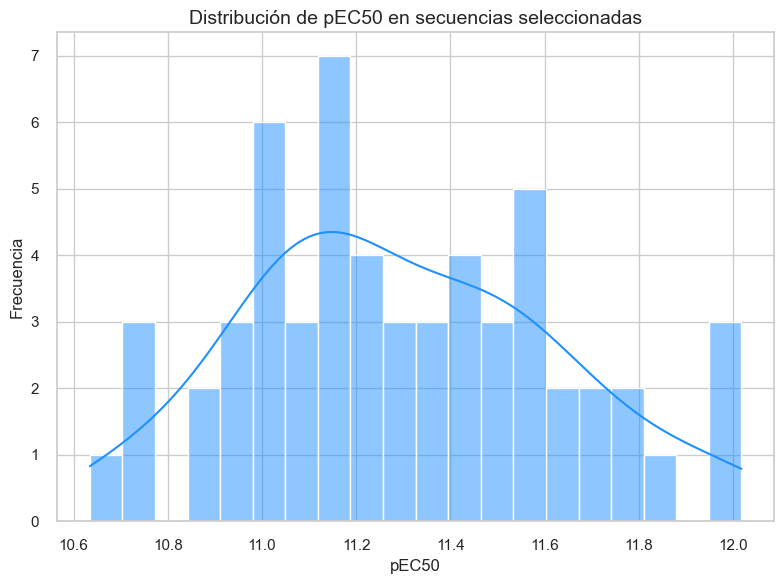

In [11]:
# Comparación de la distribución de pEC50 de las secuencias seleccionadas como semilla
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración del estilo de la visualización
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.histplot(df_todas_actividades['pEC50'], kde=True, bins=20, color='dodgerblue')
plt.title('Distribución de pEC50 en secuencias seleccionadas', fontsize=14)
plt.xlabel('pEC50', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.tight_layout()
plt.show()

### Generación de nuevas secuencias usando modelo generatívo

Para la generación de nuevas secuencias peptídicas con potencial actividad agonista de GLP-1, se empleó un modelo de lenguaje preentrenado basado en la arquitectura ProtXLNet. Este modelo fue seleccionado debido a su capacidad para capturar patrones complejos en secuencias biológicas y generar variantes que conservan características funcionales similares a las secuencias de entrada.

Sin embargo, el modelo ProtXLNet presenta ciertas limitaciones. Una de ellas es la longitud máxima de secuencia que puede procesar en un tiempo determinado, lo que restringe el tamaño de las secuencias peptídicas que pueden utilizarse como prompt. Otra limitación radica en la diversidad de las secuencias generadas, ya que el modelo tiende a producir variantes muy similares a las secuencias de entrada o a repetir patrones de aminoácidos, lo que dificulta su uso directo para la generación de nuevas secuencias. No obstante, al introducir mutaciones controladas en las secuencias de entrada, el modelo es capaz de generar secuencias funcionales viables que mantienen características relevantes para la actividad biológica.

Previo a la generación, el modelo fue ajustado utilizando las secuencias más diversas obtenidas mediante técnicas de clustering (cd-hit), lo que resultó en un conjunto de 225 secuencias altamente diversas. Estas fueron empleadas con el objetivo de maximizar la variabilidad durante el proceso de entrenamiento.

In [12]:
# Uso del modelo ProtXLNet para la generación de nuevas secuencias

# Configuración del modelo generativo ProtXLNet
longitud_maxima = df_todas_actividades['sequence'].str.len().max()
longitud_minima = df_todas_actividades['sequence'].str.len().min()
sequences_base = df_todas_actividades['sequence'].tolist()
print(f"Longitud máxima de secuencia: {longitud_maxima}")
print(f"Longitud mínima de secuencia: {longitud_minima}")

# Generación de nuevas secuencias usando ProtXLNet
from src.ProtXLNet_generator import generate_peptide_variants, generate_peptide_variants_fast
# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

print(f"Cargando modelo desde: {ruta_modelo_protxlnet}")
tokenizer = XLNetTokenizer.from_pretrained(ruta_modelo_protxlnet)
model = XLNetLMHeadModel.from_pretrained(ruta_modelo_protxlnet)
model.to(device)
# Generación de nuevas secuencias
print("\nIniciando la generación de variantes con la función importada...")

# Llama a la función
nuevas_variantes = generate_peptide_variants_fast  (
    prompt_sequences=sequences_base,
    model=model,
    tokenizer=tokenizer,
    top_k=5,
    num_variants_per_seq=30, # Generar N variantes por cada secuencia base
    min_length=longitud_minima,
    max_length=longitud_maxima
)

# liberar los recursos del modelo generativo
if model is not None:
    del model
if tokenizer is not None:
    del tokenizer
if device.type == 'cuda':
    torch.cuda.empty_cache()

Longitud máxima de secuencia: 41
Longitud mínima de secuencia: 29
Usando dispositivo: cuda
Cargando modelo desde: d:\source\Proyecto Integrador\glp-1_drug_discovery\models\prot_xlnet_finetuned

Iniciando la generación de variantes con la función importada...
Generando 1710 variantes en lotes de 32...


Generando:   0%|          | 0/54 [00:00<?, ?it/s]

This is a friendly reminder - the current text generation call has exceeded the model's predefined maximum length (-1). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.



Generación completada. Se obtuvieron 2167 variantes únicas.


In [13]:
# Crear un DataFrame con las nuevas secuencias generadas

df_secuencias_nuevas = pd.DataFrame(nuevas_variantes, columns=["sequence"])
df_secuencias_nuevas['ID'] = [f"secuencia_{idx}" for idx in range(1, len(df_secuencias_nuevas) + 1)]
df_secuencias_nuevas = df_secuencias_nuevas[['ID', 'sequence']]
df_secuencias_nuevas.head(10)

ID                                 sequence
0   secuencia_1          HAEGTFTSDVSAYLEGQAADEFIAWLVKGRH
1   secuencia_2  YAEGTFTSDYSIYHDRQAAQEFVNWLLAGGPSSGAPPPS
2   secuencia_3        HTDGTFTSDVSAYRNDRAVKEFVARLKSGQSAR
3   secuencia_4  YAEGTFTSDYSIYLDKQAAEWFVNWLLAGGPSSGAPPPS
4   secuencia_5           KSQGTFTSDYSKYLESERARDFVQWLVAGG
5   secuencia_6           HTDGTFTIDVSAYLNDRAVKEFVARLKSGQ
6   secuencia_7            HAEGTFTSDVSSYLEGQAAKEAIAWLVGR
7   secuencia_8          YSEGTFTSDYSKLLEEEAVRLFCEWLVKGPH
8   secuencia_9           IAEGTFTSDVSSYLEGQAAKEFIAWLKGRH
9  secuencia_10         HSIGTFTSDYSKYLDSERADDFVQWLVAGGHH

In [14]:
# Generar un timestamp para nombrar archivos a final de evitar sobreescrituras de resultados
from datetime import datetime

# Generar timestamp en formato AñoMesDía_HoraMinutoSegundo
File_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

In [15]:
# guardar en un archivo CSV las nuevas secuencias generadas

# Guardar df_seccuencias_nuevas en CSV con timestamp

nombre_archivo_csv = f"secuencias_nuevas_{File_timestamp}.csv"

# Guardar el DataFrame en CSV
ruta_salida_secuencias_nuevas = Path(directorio_nuevas_secuencias /nombre_archivo_csv)

df_secuencias_nuevas.to_csv(ruta_salida_secuencias_nuevas, index=False)
print(f"Archivo guardado: {ruta_salida_secuencias_nuevas}")

Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\secuencias_nuevas\secuencias_nuevas_20251019_203718.csv


In [16]:
# # #  cargar los datos en caso de ser necesario
# df_secuencias_nuevas = pd.read_csv(Path(directorio_nuevas_secuencias / f"secuencias_nuevas_{"20251019_182315"}.csv"))

# df_secuencias_nuevas.head()

## Calculo de las propiedades fisico químicas de las nuevas secuencias generadas

Con las nuevas secuencias generadas, se procedió a evaluar sus propiedades fisicoquímicas utilizando iFeature. Este análisis incluyó la predicción de características clave como la hidrofobicidad, carga neta, punto isoeléctrico, y otras propiedades relevantes que pueden influir en la actividad biológica y la estabilidad de los péptidos. Estas características son las mismas que se utilizaron en el entrenamiento del modelo predictivo:

### Resumen de Descriptores de Péptidos

* **`AAC` (Amino Acid Composition)**: Frecuencia de cada uno de los 20 aminoácidos en la secuencia. Ignora el orden.

* **`CKSAAGP` (Composition of k-Spaced Amino Acid Group Pairs)**: Frecuencia de pares de **grupos** de aminoácidos separados por una distancia 'k'. Captura relaciones a media/larga distancia.

* **`DPC` (Dipeptide Composition)**: Frecuencia de todos los 400 pares de aminoácidos adyacentes posibles. Captura el orden local.

* **`CTD` (Composition, Transition, Distribution)**: Un conjunto de 3 descriptores basados en agrupar aminoácidos por 7 propiedades fisicoquímicas:
    * **`CTDC` (Composition)**: % de aminoácidos que pertenecen a cada grupo.
    * **`CTDT` (Transition)**: Frecuencia de cambio de un grupo a otro.
    * **`CTDD` (Distribution)**: Posición (al 1%, 25%, 50%, 75%, 100%) donde se encuentra cada grupo.

* **`CTriad` (Conjoint Triad)**: Frecuencia de tríadas (tres grupos adyacentes) de aminoácidos, después de agruparlos en 7 clases fisicoquímicas.

* **`GAAC` (Grouped Amino Acid Composition)**: Frecuencia de **grupos** de aminoácidos (ej. alifáticos, aromáticos), en lugar de aminoácidos individuales.

* **`Moran` (Moran Autocorrelation)**: Mide cómo se correlaciona una propiedad fisicoquímica consigo misma a diferentes distancias a lo largo de la secuencia.

* **`SOCNumber` (Sequence-Order-Coupling Number)**: Captura el orden de la secuencia basándose en la "distancia" fisicoquímica entre aminoácidos a lo largo de la cadena.

* **`QSOrder` (Quasi-Sequence-Order)**: Combina información del orden local (como DPC) y global de la secuencia usando distancias fisicoquímicas.

* **`PAAC` (Pseudo-Amino Acid Composition)**: Una versión mejorada de AAC que añade factores de correlación para reflejar el orden de la secuencia y las propiedades de los vecinos.

* **`APAAC` (Amphiphilic PAAC)**: Una variante de PAAC que incorpora específicamente propiedades de hidrofobicidad e hidrofilicidad, útil para péptidos anfipáticos.

* **`NMBroto` (Auto-Cross Covariance)**: Mide la correlación entre propiedades fisicoquímicas. La **autocovarianza** es para la misma propiedad a diferentes distancias; la **covarianza cruzada** es entre dos propiedades diferentes.

(Chou, 2001)

### Ejecución del calculo de descriptores fisicoquímicos usando iFeature
iFeature requiere que las secuencias estén en un archivo FASTA. Por lo tanto, se creó un archivo FASTA temporal con las nuevas secuencias generadas y se ejecutó iFeature para calcular los descriptores fisicoquímicos.

In [17]:
# Guardar las nuevas variantes generadas en formato FASTA
from src.bio_utils import save_df_as_fasta, fasta_to_dataframe, inspect_fasta_file

nombre_archivo_fasta = f"secuencias_nuevas_{File_timestamp}.fasta"
ruta_salida_fasta = Path(directorio_nuevas_secuencias /nombre_archivo_fasta)

save_df_as_fasta(
    dataframe=df_secuencias_nuevas,
    id_col='ID',
    seq_col='sequence',
    output_file=ruta_salida_fasta
    
)

results = inspect_fasta_file(ruta_salida_fasta)

if results and results['is_valid']:
    print(f"'{ruta_salida_fasta}' es válido.")
    print(f"Se encontraron {results['record_count']} registros válidos.")
else:
    print(f"\nLa validación falló para '{ruta_salida_fasta}'. Por favor, revisa los registros.")

Success! DataFrame has been saved to 'd:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\secuencias_nuevas\secuencias_nuevas_20251019_203718.fasta'.
Inspecting file: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\secuencias_nuevas\secuencias_nuevas_20251019_203718.fasta...
  - OK! File is structurally valid. Found 2167 records.
'd:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\secuencias_nuevas\secuencias_nuevas_20251019_203718.fasta' es válido.
Se encontraron 2167 registros válidos.


In [18]:
### Cálculo de Características con iFeature Omega

from src.ifeature_process import *

# cargar las configuraciónes
ifeatures_settings_json = Path(directorio_datos / 
                               "iFeature Settings" / 
                               "Protein_parameters_setting.json") 
ifeatures_settings_json

WindowsPath('d:/source/Proyecto Integrador/glp-1_drug_discovery/data/iFeature Settings/Protein_parameters_setting.json')

In [19]:
# Definimos una lista de descriptores
descriptores = [
            "AAC",				# Amino acid composition
            "CKSAAGP type 1",	# Composition of k-spaced amino acid group pairs type 1- normalized
            "DPC type 1",		# Dipeptide composition type 1 - normalized
            "CTDC",				# Composition
            "CTDT",				# Transition
            "CTDD",				# Distribution
            "CTriad",			# Conjoint triad
            "GAAC",				# Grouped amino acid composition
            "Moran",			# Moran
            "SOCNumber",		# Sequence-order-coupling number
            "QSOrder",			# Quasi-sequence-order descriptors
            "PAAC",				# Pseudo-amino acid composition
            "APAAC",			# Amphiphilic PAAC
            "NMBroto",			# Auto-cross covariance
        ]

In [20]:
# Calculamos los descriptores
df_descriptores_ifeature = compute_peptide_features(ruta_salida_fasta, descriptores, ifeatures_settings_json)

Calculando descriptor: AAC
File imported successfully.
Calculando descriptor: CKSAAGP type 1
File imported successfully.
Calculando descriptor: DPC type 1
File imported successfully.
Calculando descriptor: CTDC
File imported successfully.
Calculando descriptor: CTDT
File imported successfully.
Calculando descriptor: CTDD
File imported successfully.
Calculando descriptor: CTriad
File imported successfully.
Calculando descriptor: GAAC
File imported successfully.
Calculando descriptor: Moran
File imported successfully.
Calculando descriptor: SOCNumber
File imported successfully.
Calculando descriptor: QSOrder
File imported successfully.
Calculando descriptor: PAAC
File imported successfully.
Calculando descriptor: APAAC
File imported successfully.
Calculando descriptor: NMBroto
File imported successfully.


#### Resultados del cálculo de descriptores fisicoquímicos

In [21]:
# Resultados de iFeatured
#df_descriptores_ifeature.head())
# Unión de los dataframes de las propiedades con los datos de identificación y las secuencias

df_secuencias_nuevas = pd.merge(
    left=df_descriptores_ifeature,         
    right=df_secuencias_nuevas[['ID','sequence']], 
    left_on='ID',                      
    right_on='ID',                 
    how='inner'                        
)

df_secuencias_nuevas.head()

ID     AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
0  secuencia_1  0.161290    0.0  0.064516  0.096774  0.064516  0.096774   
1  secuencia_2  0.128205    0.0  0.051282  0.051282  0.051282  0.102564   
2  secuencia_3  0.121212    0.0  0.090909  0.030303  0.060606  0.060606   
3  secuencia_4  0.128205    0.0  0.051282  0.051282  0.051282  0.102564   
4  secuencia_5  0.066667    0.0  0.066667  0.066667  0.066667  0.100000   

      AAC_H     AAC_I     AAC_K  ...  NMBroto_BEGF750102.lag1  \
0  0.064516  0.032258  0.032258  ...                 0.024282   
1  0.025641  0.025641  0.000000  ...                 0.229378   
2  0.030303  0.000000  0.060606  ...                 0.062958   
3  0.000000  0.025641  0.025641  ...                 0.294781   
4  0.000000  0.000000  0.066667  ...                 0.309343   

   NMBroto_BEGF750102.lag2  NMBroto_BEGF750102.lag3  NMBroto_BEGF750103.lag1  \
0                -0.383661                -0.137070                -0.014118   
1                -0.031764                 0.059281                 0.254109   
2                -0.349356                 0.032887                 0.120054   
3                -0.038050                -0.049066                 0.129099   
4                -0.211072                 0.014030                 0.072748   

   NMBroto_BEGF750103.lag2  NMBroto_BEGF750103.lag3  NMBroto_BHAR880101.lag1  \
0                -0.161744                 0.082607                 0.132180   
1                -0.073772                -0.194492                 0.279316   
2                 0.198348                -0.227991                 0.057497   
3                -0.167582                -0.184740                 0.287189   
4                -0.284620                -0.151165                 0.189228   

   NMBroto_BHAR880101.lag2  NMBroto_BHAR880101.lag3  \
0                -0.320912                -0.296636   
1                -0.089597                 0.071286   
2                -0.039846                -0.120947   
3                 0.053265                 0.145739   
4                -0.121735                 0.179244   

                                  sequence  
0          HAEGTFTSDVSAYLEGQAADEFIAWLVKGRH  
1  YAEGTFTSDYSIYHDRQAAQEFVNWLLAGGPSSGAPPPS  
2        HTDGTFTSDVSAYRNDRAVKEFVARLKSGQSAR  
3  YAEGTFTSDYSIYLDKQAAEWFVNWLLAGGPSSGAPPPS  
4           KSQGTFTSDYSKYLESERARDFVQWLVAGG  

[5 rows x 1292 columns]

### Predicción de las propiedades de actividad biológica de las nuevas secuencias generadas

Usando el modelo previamente entrenado para predecir la actividad biológica (pEC50), se evaluaron las nuevas secuencias generadas para identificar aquellas con mayor potencial como agonistas de GLP-1. Debido la limitacion del conjunto de datos para entrenar el modelo predictivo las predicciones deben tomarse con precaución y considerarse como una guía inicial para la selección de candidatos.



In [22]:
## Ajustar el nombre de las columnas y realizar las predicciones
df_secuencias_nuevas.columns = df_secuencias_nuevas.columns.str.replace('.', '_', regex=False)
df_predicciones_nuevos = predict_model(modelo_pycaret, data=df_secuencias_nuevas)
df_predicciones_nuevos.rename(columns={'prediction_label': 'pEC50'}, inplace=True)
df_predicciones_nuevos.sort_values(by='pEC50', ascending=False, inplace=True)
df_predicciones_nuevos.head(10)

ID     AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
2029  secuencia_2030  0.076923    0.0  0.051282  0.128205  0.051282  0.102564   
1676  secuencia_1677  0.076923    0.0  0.051282  0.076923  0.051282  0.102564   
1051  secuencia_1052  0.172414    0.0  0.034483  0.103448  0.068966  0.103448   
532    secuencia_533  0.051282    0.0  0.051282  0.128205  0.051282  0.102564   
675    secuencia_676  0.076923    0.0  0.051282  0.128205  0.051282  0.102564   
1054  secuencia_1055  0.076923    0.0  0.051282  0.128205  0.051282  0.076923   
44      secuencia_45  0.051282    0.0  0.051282  0.076923  0.076923  0.102564   
782    secuencia_783  0.100000    0.0  0.100000  0.033333  0.066667  0.100000   
387    secuencia_388  0.051282    0.0  0.051282  0.076923  0.051282  0.102564   
185    secuencia_186  0.076923    0.0  0.051282  0.128205  0.051282  0.102564   

         AAC_H     AAC_I     AAC_K  ...  NMBroto_BEGF750102_lag2  \
2029  0.000000  0.025641  0.025641  ...                -0.210823   
1676  0.000000  0.025641  0.051282  ...                -0.212297   
1051  0.034483  0.034483  0.068966  ...                -0.407650   
532   0.000000  0.025641  0.025641  ...                -0.124978   
675   0.000000  0.025641  0.000000  ...                -0.092786   
1054  0.000000  0.025641  0.025641  ...                -0.274609   
44    0.000000  0.025641  0.051282  ...                -0.236429   
782   0.033333  0.000000  0.033333  ...                -0.371645   
387   0.000000  0.025641  0.025641  ...                -0.171078   
185   0.000000  0.025641  0.025641  ...                -0.125669   

      NMBroto_BEGF750102_lag3  NMBroto_BEGF750103_lag1  \
2029                -0.037422                 0.214354   
1676                 0.158681                 0.087608   
1051                -0.148092                 0.029052   
532                  0.121335                 0.335551   
675                  0.052417                 0.315398   
1054                -0.041919                 0.366654   
44                   0.259195                 0.192723   
782                 -0.142077                 0.069161   
387                  0.200098                 0.195802   
185                  0.111158                 0.348542   

      NMBroto_BEGF750103_lag2  NMBroto_BEGF750103_lag3  \
2029                 0.035915                -0.162513   
1676                -0.050138                -0.145949   
1051                 0.043024                 0.162188   
532                  0.021757                 0.138214   
675                  0.001059                -0.008898   
1054                -0.070559                -0.117724   
44                  -0.080814                 0.004414   
782                 -0.225640                -0.071769   
387                 -0.077651                 0.033207   
185                  0.045705                -0.020870   

      NMBroto_BHAR880101_lag1  NMBroto_BHAR880101_lag2  \
2029                 0.188863                -0.072045   
1676                 0.245833                 0.031031   
1051                 0.181194                -0.284650   
532                  0.323329                -0.026461   
675                  0.289648                -0.083706   
1054                 0.274562                -0.232971   
44                   0.402671                 0.022825   
782                  0.105155                -0.129817   
387                  0.379036                 0.053143   
185                  0.256228                -0.108470   

      NMBroto_BHAR880101_lag3                                 sequence  \
2029                 0.019760  YSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPSVGAPPPS   
1676                -0.057415  YSEGTFTSDYSKLLERQAIDEFVNWLLKGGPSAGAPPPS   
1051                -0.381103            HAEGTFTSDVSAYLEGQAAKEFIAWLKGR   
532                  0.093315  YSEGTFTSDYSKLLEEEAVRDFIEWLLRGGPSSGAPPPS   
675                  0.163567  YSEGTFTSDYSRLLEEEAVRDFIEWLLAGGPSSGAPPPS   
1054            

In [23]:
# Guardar el DataFrame en CSV
nombre_predicciones_csv = f"predicciones_{File_timestamp}.csv"
ruta_salida_csv = Path(directorio_nuevas_secuencias /nombre_predicciones_csv)

df_predicciones_nuevos.to_csv(ruta_salida_csv, index=False)
print(f"Archivo guardado: {ruta_salida_csv}")


Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\secuencias_nuevas\predicciones_20251019_203718.csv


In [24]:
# # cargar las predicciones en caso de ser necesario
# # Guardar el DataFrame en CSV
# nombre_predicciones_csv = f"predicciones_20251018_202905.csv"
# ruta_salida_csv = Path(directorio_nuevas_secuencias /nombre_predicciones_csv)

# df_predicciones_nuevos = pd.read_csv(ruta_salida_csv)
# df_predicciones_nuevos.head()

#### Resultados de la predicción de actividad biológica (pEC50) para las nuevas secuencias generadas

Para evaluar la calidad de las nuevas secuencias generadas, se clasificaron de acuerdo al resultado de la predicción de actividad biológica (pEC50) en las siguientes categorías de acuerdo a su potencial actividad:

- Baja: pEC50 < Q33
- Media: Q33 ≤ pEC50 < Q66
- Alta: pEC50 ≥ Q66

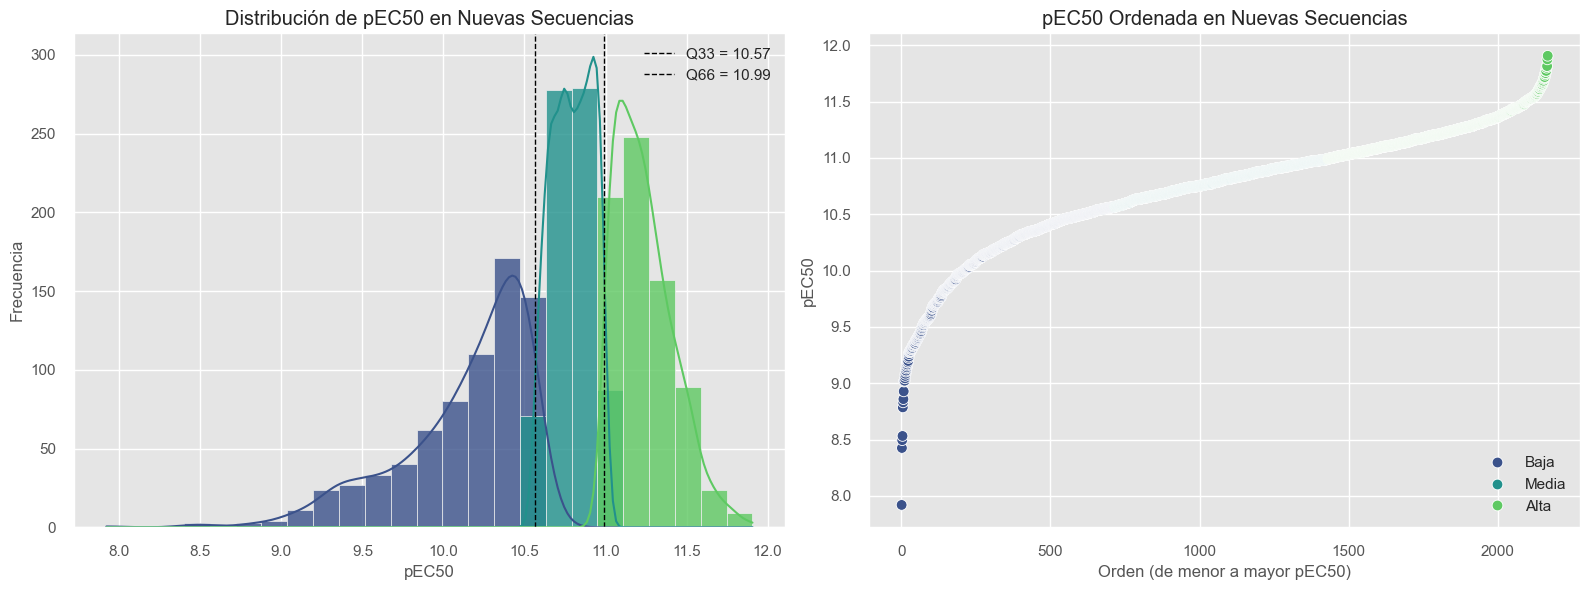


Resumen por categoría:
            n   promedio        min        max
Potencia                                      
Alta      737  11.240055  10.992917  11.906929
Baja      715  10.126113   7.920140  10.565440
Media     715  10.795223  10.565883  10.992725

Top 15 registros de categoría "Alta":


ID      pEC50 Potencia
2029  secuencia_2030  11.906929     Alta
1676  secuencia_1677  11.875434     Alta
1051  secuencia_1052  11.815505     Alta
532    secuencia_533  11.815175     Alta
675    secuencia_676  11.800893     Alta
1054  secuencia_1055  11.772759     Alta
44      secuencia_45  11.770556     Alta
782    secuencia_783  11.753852     Alta
387    secuencia_388  11.750315     Alta
185    secuencia_186  11.738632     Alta
678    secuencia_679  11.718551     Alta
1213  secuencia_1214  11.714096     Alta
1870  secuencia_1871  11.709286     Alta
1703  secuencia_1704  11.701035     Alta
1549  secuencia_1550  11.685920     Alta

In [37]:
# Clasificación y gráficos basados en cuantiles de solubilidad
%matplotlib inline 
clasificar_y_graficar_cuantiles(
    df_input=df_predicciones_nuevos,   columna_valor='pEC50', 
    columna_id='ID', top_n=15,palette='viridis',
    titulo_distribucion='Distribución de pEC50 en Nuevas Secuencias',
    titulo_ordenado='pEC50 Ordenada en Nuevas Secuencias'
)

### Cálculo de propiedades de hemólisis, solubilidad, no adherencia y fouling de las nuevas secuencias generadas

Las nuevas secuencias generadas fueron evaluadas mediante el modelo PeptideBERT que es un modelo de aprendizaje profundo diseñado para predecir propiedades de hemólisis, solubilidad y no adherencia/fouling sobre secuencias de proteínas.

Para cada una de las nuevas secuencias generadas, se calcularon las siguientes propiedades:

* Hemólisis: se refiere a la capacidad del péptido para causar la ruptura de eritrocitos, lo que representa un indicador clave de toxicidad.

* Solubilidad: mide la facilidad con la que el péptido puede disolverse en medios acuosos, aspecto importante para su formulación y biodisponibilidad como medicamento.

* Fouling (o bioincrustación): corresponde a la tendencia del péptido a adherirse a superficies biológicas o sintéticas, generando agregados no deseados o interacciones que limiten su eficacia funcional.

Este análisis nos permite identificar péptidos que presentan un potencial agonista sobre GLP-1, y que también exhiben características favorables en términos de seguridad, estabilidad y viabilidad. 

Las secuencias con baja hemólisis, alta solubilidad y baja propensión al fouling serán priorizadas para estudios adicionales. En contraste, aquellas con baja solubilidad podrían presentar problemas en formulación y biodisponibilidad, mientras que las que exhiban una alta actividad hemolítica serán descartadas debido a su potencial toxicidad. Cabe aclarar que estos datos son predicciones computacionales y requieren validación experimental para confirmar su relevancia biológica.

Es importante aclarar que en las secuencias generadas no se encontraron secuencias con alta hemólisis, por lo que en general las secuencias generadas presentan un perfil favorable en términos de toxicidad.

### Modelo Predictivo PeptideBERT

PeptideBERT es un modelo de lenguaje basado en la arquitectura BERT (Bidirectional Encoder Representations from Transformers) diseñado específicamente para trabajar con secuencias de péptidos. Este modelo ha sido entrenado en grandes conjuntos de datos de secuencias peptídicas para aprender representaciones profundas que capturan las características y propiedades inherentes de los péptidos. Estas representaciones permiten a PeptideBERT realizar diversas tareas de predicción relacionadas con las propiedades biológicas y fisicoquímicas de los péptidos, incluyendo la predicción de hemólisis, solubilidad y no adherencia/fouling (Guntuboina et al., 2023).

In [26]:
# Preparación de datos y modelos para ejecutar peptideBERT
import yaml
from models.peptideBert.network import create_model

def load_bert_model(feature, device):
    config = yaml.load(open(f'{directorio_modelos_peptidebert}/{feature}/config.yaml', 'r'), Loader=yaml.FullLoader)
    config['device'] = device
    model = create_model(config)
    model.load_state_dict(torch.load(f'{directorio_modelos_peptidebert}/{feature}/model.pt',weights_only = False)['model_state_dict'], strict=False)
    return model

In [27]:
# Funcion para ejecutar peptideBERT

def predict_peptidebert(sequences,feats=['hemo','sol','nf']):
    peptides =sequences.copy()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Usando dispositivo: {device}')
    MAX_LEN = max(map(len, sequences))
    # convert to tokens
    mapping = dict(zip(
        ['[PAD]','[UNK]','[CLS]','[SEP]','[MASK]','L',
        'A','G','V','E','S','I','K','R','D','T','P','N',
        'Q','F','Y','M','H','C','W'],
        range(30)
    ))

    
    for i in range(len(sequences)):
        sequences[i] = [mapping[c] for c in sequences[i]] 
        sequences[i].extend([0] * (MAX_LEN - len(sequences[i])))  # padding to max length
    
    results = pd.DataFrame({'Sequence':peptides})
    feats = feats
    with torch.inference_mode():
        for c in feats:
            model = load_bert_model(c,device)
            preds = []
            for i in range(len(sequences)):
                input_ids = torch.tensor([sequences[i]]).to(device)
                attention_mask = (input_ids != 0).float()
                output = float(model(input_ids, attention_mask)[0])
                preds.append(output)
                
            if model is not None:
                del model
            if device.type == 'cuda':
                torch.cuda.empty_cache()
                
            results = pd.concat([results,pd.DataFrame(preds, columns = [c]).astype(float)], axis=1)
    
    return results
    

In [28]:
# Ejecutar peptideBERT en las nuevas secuencias generadas
seqs = df_secuencias_nuevas['sequence'].tolist()
bert_results = predict_peptidebert(seqs, ['hemo','sol', 'nf'])

Usando dispositivo: cuda


In [30]:
# Union de las características de peptideBERT con las predicciones previas
df_final_bert = pd.merge(df_predicciones_nuevos, bert_results, left_on='sequence', right_on='Sequence', how='inner')
df_final_bert.drop(columns=['Sequence'], inplace=True)
df_final_bert.head()

ID     AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
0  secuencia_2030  0.076923    0.0  0.051282  0.128205  0.051282  0.102564   
1  secuencia_1677  0.076923    0.0  0.051282  0.076923  0.051282  0.102564   
2  secuencia_1052  0.172414    0.0  0.034483  0.103448  0.068966  0.103448   
3   secuencia_533  0.051282    0.0  0.051282  0.128205  0.051282  0.102564   
4   secuencia_676  0.076923    0.0  0.051282  0.128205  0.051282  0.102564   

      AAC_H     AAC_I     AAC_K  ...  NMBroto_BEGF750103_lag2  \
0  0.000000  0.025641  0.025641  ...                 0.035915   
1  0.000000  0.025641  0.051282  ...                -0.050138   
2  0.034483  0.034483  0.068966  ...                 0.043024   
3  0.000000  0.025641  0.025641  ...                 0.021757   
4  0.000000  0.025641  0.000000  ...                 0.001059   

   NMBroto_BEGF750103_lag3  NMBroto_BHAR880101_lag1  NMBroto_BHAR880101_lag2  \
0                -0.162513                 0.188863                -0.072045   
1                -0.145949                 0.245833                 0.031031   
2                 0.162188                 0.181194                -0.284650   
3                 0.138214                 0.323329                -0.026461   
4                -0.008898                 0.289648                -0.083706   

   NMBroto_BHAR880101_lag3                                 sequence  \
0                 0.019760  YSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPSVGAPPPS   
1                -0.057415  YSEGTFTSDYSKLLERQAIDEFVNWLLKGGPSAGAPPPS   
2                -0.381103            HAEGTFTSDVSAYLEGQAAKEFIAWLKGR   
3                 0.093315  YSEGTFTSDYSKLLEEEAVRDFIEWLLRGGPSSGAPPPS   
4                 0.163567  YSEGTFTSDYSRLLEEEAVRDFIEWLLAGGPSSGAPPPS   

       pEC50      hemo       sol        nf  
0  11.906929  0.072535  0.694430  0.008879  
1  11.875434  0.066084  0.662198  0.011589  
2  11.815505  0.061767  0.781157  0.009229  
3  11.815175  0.070100  0.692213  0.012149  
4  11.800893  0.073456  0.637524  0.011249  

[5 rows x 1296 columns]

In [31]:
# Guardar los resultados de peptideBERT
nombre_bert_csv = f"bert_vegf_features_{File_timestamp}.csv"
ruta_salida_peptideBert_csv = Path(directorio_nuevas_secuencias /nombre_bert_csv)
df_final_bert.to_csv(ruta_salida_peptideBert_csv, index=False)
print(f"Archivo guardado: {ruta_salida_peptideBert_csv}")


Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\secuencias_nuevas\bert_vegf_features_20251019_203718.csv


In [ ]:
# # cargar los resultados de peptideBERT en caso de ser necesario
# nombre_bert_csv = f"bert_vegf_features_20251019_182315.csv"
# df_final_bert = pd.read_csv(directorio_nuevas_secuencias/nombre_bert_csv)
# df_final_bert.head()

## Filtrado de las secuencias generadas según las propiedades calculadas

#### Grafico de la solubilidad de las secuencias generadas

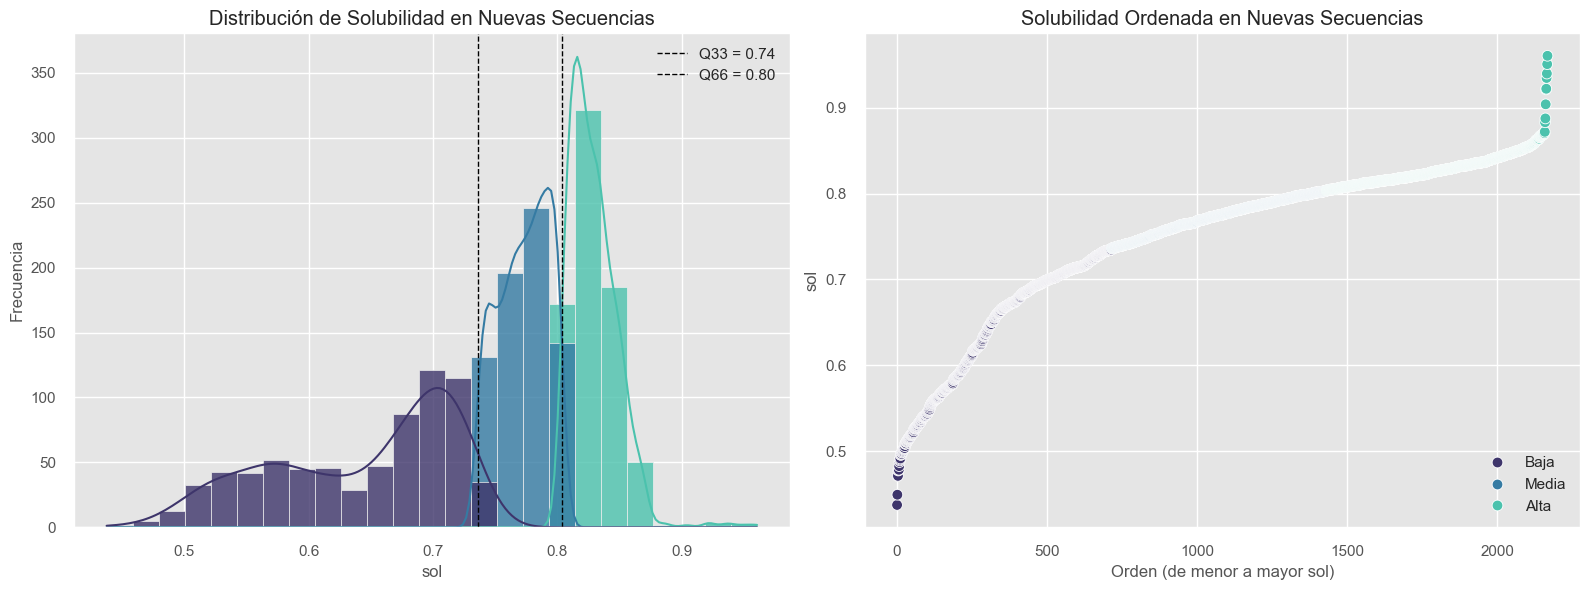


Resumen por categoría:
            n  promedio       min       max
Potencia                                   
Alta      737  0.829281  0.803500  0.960591
Baja      715  0.641732  0.437371  0.734824
Media     715  0.772966  0.736136  0.803316

Top 15 registros de categoría "Alta":


ID       sol Potencia
579   secuencia_1843  0.960591     Alta
1323   secuencia_995  0.950857     Alta
1706  secuencia_1652  0.939884     Alta
917   secuencia_1623  0.934755     Alta
550   secuencia_1716  0.922201     Alta
675    secuencia_109  0.921473     Alta
1091   secuencia_822  0.904064     Alta
619    secuencia_819  0.887610     Alta
1000   secuencia_592  0.883160     Alta
141    secuencia_537  0.872034     Alta
492    secuencia_725  0.870478     Alta
1549  secuencia_1620  0.870279     Alta
424   secuencia_1462  0.870192     Alta
462   secuencia_1846  0.869956     Alta
509   secuencia_1297  0.869356     Alta

In [39]:
# Clasificación y gráficos basados en cuantiles de solubilidad
clasificar_y_graficar_cuantiles(
    df_input=df_final_bert,   columna_valor='sol', 
    columna_id='ID', top_n=15,palette='mako',
    titulo_distribucion='Distribución de Solubilidad en Nuevas Secuencias',
    titulo_ordenado='Solubilidad Ordenada en Nuevas Secuencias'
)

#### Grafico de la Hemolisis de las secuencias generadas

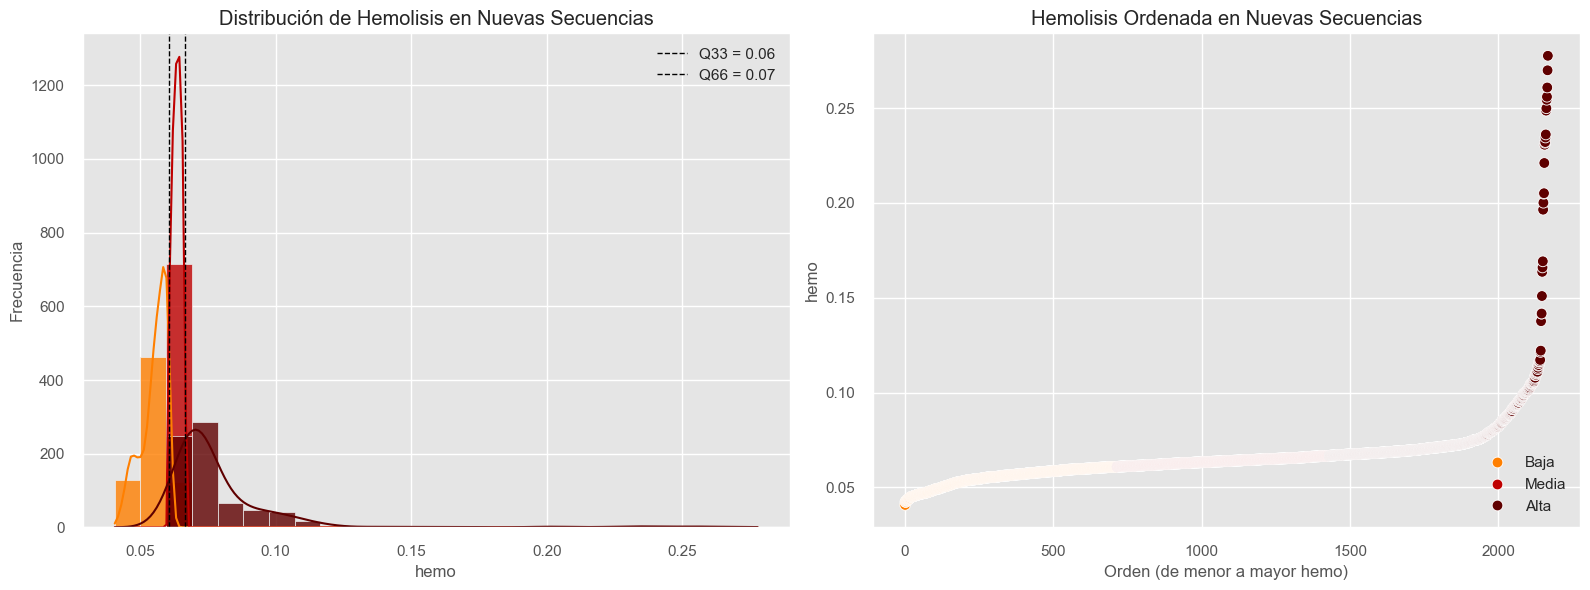


Resumen por categoría:
            n  promedio       min       max
Potencia                                   
Alta      737  0.080410  0.066662  0.277656
Baja      715  0.055198  0.040718  0.060807
Media     715  0.063744  0.060819  0.066661

Top 15 registros de categoría "Alta":


ID      hemo Potencia
864    secuencia_158  0.277656     Alta
1711   secuencia_790  0.269994     Alta
499    secuencia_549  0.260933     Alta
1800  secuencia_2039  0.256058     Alta
596    secuencia_436  0.254461     Alta
1171  secuencia_1253  0.249979     Alta
353   secuencia_2166  0.248730     Alta
1263  secuencia_1135  0.236154     Alta
553   secuencia_1069  0.234551     Alta
1469   secuencia_834  0.232151     Alta
720   secuencia_1193  0.231798     Alta
792   secuencia_2148  0.230738     Alta
630   secuencia_1100  0.221103     Alta
1198   secuencia_166  0.205158     Alta
521    secuencia_515  0.204872     Alta

In [40]:
#### Grafico de la Hemolisis de las secuencias generadas
clasificar_y_graficar_cuantiles(
    df_input=df_final_bert,   columna_valor='hemo', 
    columna_id='ID', top_n=15, palette='gist_heat_r',
    titulo_distribucion='Distribución de Hemolisis en Nuevas Secuencias',
    titulo_ordenado='Hemolisis Ordenada en Nuevas Secuencias'
)

#### Grafico de Adherencia de las secuencias generadas


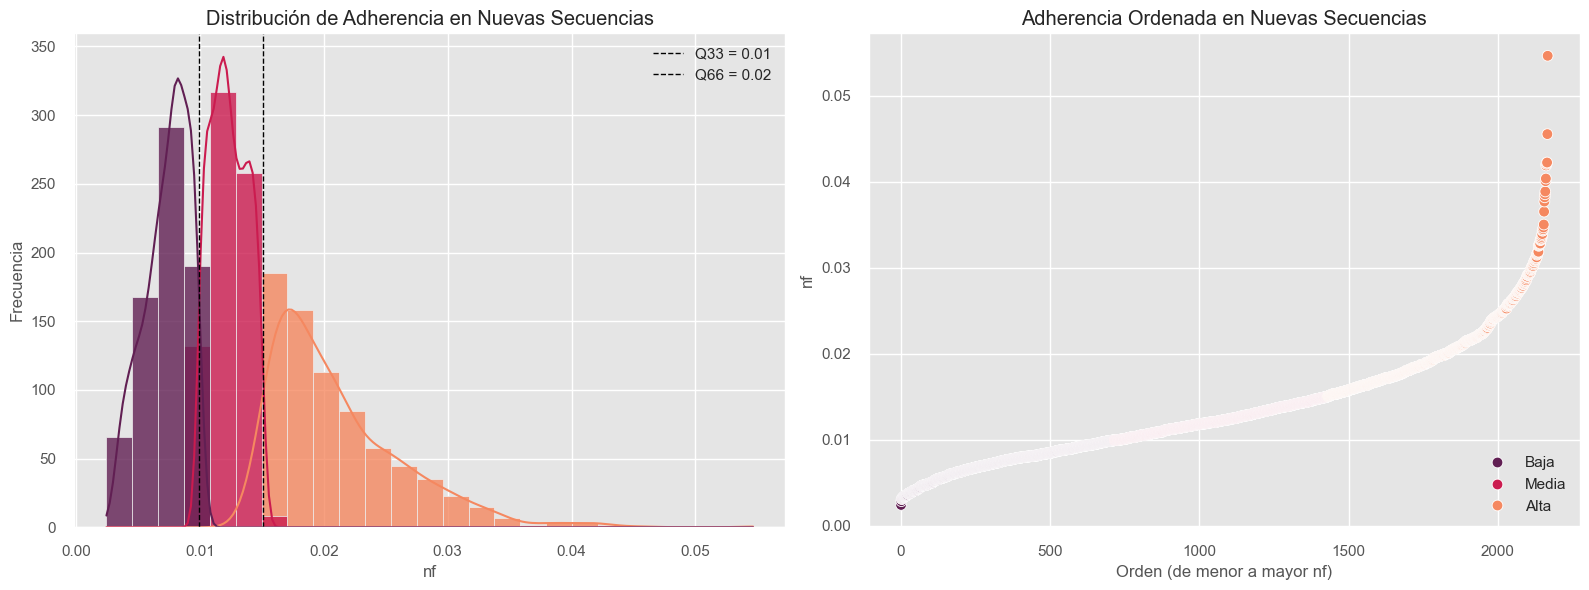


Resumen por categoría:
            n  promedio       min       max
Potencia                                   
Alta      737  0.021096  0.015046  0.054654
Baja      715  0.007320  0.002442  0.009953
Media     715  0.012355  0.009957  0.015040

Top 15 registros de categoría "Alta":


ID        nf Potencia
1850  secuencia_1188  0.054654     Alta
1004   secuencia_892  0.045550     Alta
1285   secuencia_624  0.042248     Alta
1233   secuencia_683  0.042207     Alta
1003  secuencia_2022  0.042093     Alta
492    secuencia_725  0.041907     Alta
984    secuencia_544  0.040383     Alta
1345  secuencia_1953  0.040078     Alta
1348   secuencia_919  0.038881     Alta
1193  secuencia_1824  0.038552     Alta
945    secuencia_511  0.038201     Alta
1867  secuencia_1334  0.037709     Alta
1538  secuencia_1751  0.036538     Alta
1176   secuencia_684  0.035036     Alta
854    secuencia_702  0.034700     Alta

In [42]:
# Grafico de la Adherencia de las secuencias generadas
clasificar_y_graficar_cuantiles(
    df_input=df_final_bert,   columna_valor='nf', 
    columna_id='ID', top_n=15, palette='rocket',
    titulo_distribucion='Distribución de Adherencia en Nuevas Secuencias',
    titulo_ordenado='Adherencia Ordenada en Nuevas Secuencias'
)


### Visualización y Selección de Péptidos Generados

Tras generar nuevas secuencias y predecir sus propiedades, el siguiente paso es analizar los resultados visualmente. Esto nos ayudará a entender la relación entre la actividad biológica predicha (`pEC50`) y otras propiedades fisicoquímicas deseables, como una baja toxicidad (hemólisis) y una alta solubilidad.

Crearemos un gráfico de dispersión (scatter plot) para explorar el "espacio de soluciones" de los péptidos generados. En este gráfico:
-   **Eje X:** Representará la probabilidad de ser hemolítico (`hemo`). Buscamos valores bajos.
-   **Eje Y:** Representará la probabilidad de ser soluble (`sol`). Buscamos valores altos.
-   **Color de los puntos:** Indicará el `pEC50` predicho. Buscamos colores que representen alta potencia.

Esta visualización nos permitirá identificar de manera intuitiva aquellos péptidos que cumplen simultáneamente con nuestros criterios de diseño: alta potencia, baja toxicidad y alta solubilidad.

In [43]:
#Filtrado de secuencias generadas por propiedades deseadas
df_seleccionadas = df_final_bert[(df_final_bert['hemo'] < 0.2) & (df_final_bert['sol'] > 0.5)].sort_values(by=['pEC50','sol','hemo','nf'], ascending=[False, False, True, True])
df_seleccionadas.head(200)


ID     AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
0    secuencia_2030  0.076923    0.0  0.051282  0.128205  0.051282  0.102564   
1    secuencia_1677  0.076923    0.0  0.051282  0.076923  0.051282  0.102564   
2    secuencia_1052  0.172414    0.0  0.034483  0.103448  0.068966  0.103448   
3     secuencia_533  0.051282    0.0  0.051282  0.128205  0.051282  0.102564   
4     secuencia_676  0.076923    0.0  0.051282  0.128205  0.051282  0.102564   
..              ...       ...    ...       ...       ...       ...       ...   
197  secuencia_2051  0.034483    0.0  0.068966  0.068966  0.068966  0.034483   
198   secuencia_631  0.066667    0.0  0.100000  0.066667  0.100000  0.100000   
199   secuencia_577  0.100000    0.0  0.100000  0.033333  0.066667  0.100000   
200  secuencia_1705  0.068966    0.0  0.034483  0.137931  0.068966  0.068966   
201  secuencia_1795  0.066667    0.0  0.066667  0.066667  0.066667  0.100000   

        AAC_H     AAC_I     AAC_K  ...  NMBroto_BEGF750103_lag2  \
0    0.000000  0.025641  0.025641  ...                 0.035915   
1    0.000000  0.025641  0.051282  ...                -0.050138   
2    0.034483  0.034483  0.068966  ...                 0.043024   
3    0.000000  0.025641  0.025641  ...                 0.021757   
4    0.000000  0.025641  0.000000  ...                 0.001059   
..        ...       ...       ...  ...                      ...   
197  0.034483  0.068966  0.034483  ...                -0.062223   
198  0.033333  0.000000  0.033333  ...                -0.257568   
199  0.033333  0.000000  0.033333  ...                -0.238179   
200  0.034483  0.034483  0.034483  ...                 0.091254   
201  0.033333  0.000000  0.033333  ...                -0.523257   

     NMBroto_BEGF750103_lag3  NMBroto_BHAR880101_lag1  \
0                  -0.162513                 0.188863   
1                  -0.145949                 0.245833   
2                   0.162188                 0.181194   
3                   0.138214                 0.323329   
4                  -0.008898                 0.289648   
..                       ...                      ...   
197                 0.146058                 0.083295   
198                 0.058952                 0.110356   
199                -0.027187                 0.135342   
200                 0.158312                 0.142334   
201                -0.073214                 0.176137   

     NMBroto_BHAR880101_lag2  NMBroto_BHAR880101_lag3  \
0                  -0.072045                 0.019760   
1                   0.031031                -0.057415   
2                  -0.284650                -0.381103   
3                  -0.026461                 0.093315   
4                  -0.083706                 0.163567   
..                       ...                      ...   
197                -0.294357                -0.056948   
198                -0.159956                 0.060718   
199                 0.011703                 0.130464   
200                -0.257089                -0.003983   
201                -0.174856                 0.075408   

                                    sequence      pEC50      hemo       sol  \
0    YSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPSVGAPPPS  11.906929  0.072535  0.694430   
1    YSEGTFTSDYSKLLERQAIDEFVNWLLKGGPSAGAPPPS  11.875434  0.066084  0.662198   
2              HAEGTFTSDVSAYLEGQAAKEFIAWLKGR  11.815505  0.061767  0.781157   
3    YSEGTFTSDYSKLLEEEAVRDFIEWLLRGGPSSGAPPPS  11.815175  0.070100  0.692213   
4    YSEGTFTSDYSRLLEEEAVRDFIEWLLAGGPSSGAPPPS  11.800893  0.073456  0.637524   
..                                       ...        ...       ...       ...   
197            HSIGTFTSDYSKYLDSRVASEFVQWLISE  11.335785  0.073724  0.714390   
198           HSQGTFTSDYSKYLDSERAFDFVEWLVAGG  11.334842  0.062992  0.839724   
199           HSVGTFTSDYSKYLDSERARDFVAWLVAGG  11.334751  0.067083  0.793215   
200            YSQGTFTSDYSKYLEEEAVRLFIEWHLAG  11.334342  0.085815  0.589862   
201         

In [44]:
# Guardar los resultados de las secuencias finales ordenadas por propiedades deseadas
nombre_secuencias_finales_csv = f"secuencias_finalistas_{File_timestamp}.csv"
ruta_salida_secuencias_finales_csv = Path(directorio_nuevas_secuencias /nombre_secuencias_finales_csv)

df_seleccionadas.to_csv(ruta_salida_secuencias_finales_csv, index=False)
print(f"Archivo guardado: {ruta_salida_secuencias_finales_csv}")



Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\secuencias_nuevas\secuencias_finalistas_20251019_203718.csv


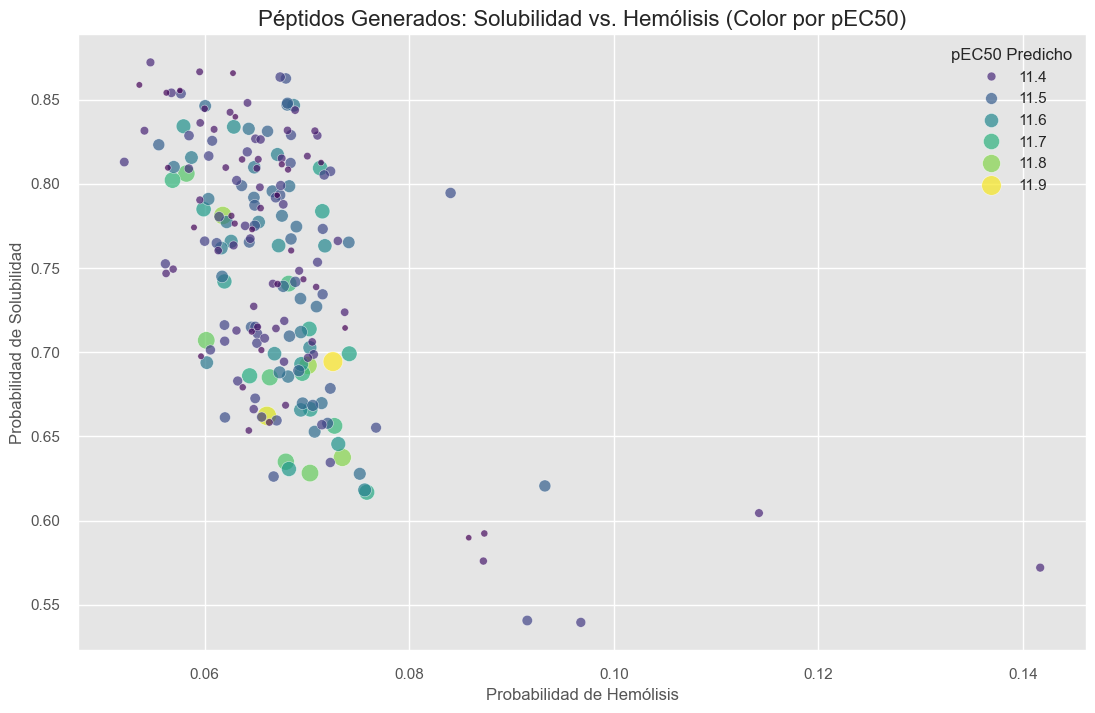

In [45]:
## Visualización de las propiedades predichas: Hemólisis vs Solubilidad coloreado por pEC50

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Crear el gráfico de dispersión
plt.figure(figsize=(13, 8))
scatter = sns.scatterplot(
    data=df_seleccionadas.head(200), # Mostrar solo las 200 secuencias con mayor pEC50
    x='hemo',
    y='sol',
    hue='pEC50',
    palette='viridis', # Usamos un mapa de color "viridis" donde los colores más claros indican valores más altos
    size='pEC50', # El tamaño del punto también representará el pEC50
    sizes=(20, 200),
    alpha=0.7,
    edgecolor='w'
)

# Añadir títulos y etiquetas
plt.title('Péptidos Generados: Solubilidad vs. Hemólisis (Color por pEC50)', fontsize=16)
plt.xlabel('Probabilidad de Hemólisis', fontsize=12)
plt.ylabel('Probabilidad de Solubilidad', fontsize=12)
plt.legend(title='pEC50 Predicho')
plt.grid(True)

# Mostrar el gráfico
plt.show()

## Visualización de los resultados obtenidos

### 6. Visualización de Descriptores con PCA

Nuestro conjunto de datos contiene 1290 descriptores fisicoquímicos para cada péptido, lo que representa un espacio de muy alta dimensionalidad. Visualizar datos en más de tres dimensiones es imposible para nosotros.

Para solucionar esto, utilizamos el **Análisis de Componentes Principales (PCA)**, una técnica de reducción de dimensionalidad que transforma los datos originales en un nuevo conjunto de variables (componentes principales) no correlacionadas. Los primeros componentes capturan la mayor parte de la varianza de los datos.

A continuación, aplicaremos PCA para reducir los 1290 descriptores a solo 3 componentes principales. Luego, crearemos un gráfico 3D donde cada punto representa un péptido, y el color de cada punto indicará su valor de `pEC50`. Esto nos permitirá observar si existen agrupaciones o patrones entre los péptidos en función de su actividad biológica.

In [50]:
# Cálculo de PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# PCA para los datos conocidos
pca = PCA(n_components=3)
principal_components_conocidos = pca.fit_transform( scaler.fit_transform(df_125_conocidos.drop(columns=[ 'EC50_T2', 'EC50_LOG_T2', 'sequence'])))
pca_df = pd.DataFrame(data=principal_components_conocidos, columns=['PC1', 'PC2', 'PC3'])
# Unir los componentes principales con la columna pEC50 usando el índice
pca_df = pca_df.set_index(df_125_conocidos.index)
df_pca_conocidos = pd.concat([pca_df, df_125_conocidos['pEC50']], axis=1)

# PCA para los datos Referencia (desconocidos )
principal_components_referencia = pca.fit_transform( scaler.fit_transform(df_predicciones_glp1.drop(columns=[  'sequence'])) )
pca_df_referencia = pd.DataFrame(data=principal_components_referencia, columns=['PC1', 'PC2', 'PC3'])
# Unir los componentes principales con la columna pEC50 usando el índice
pca_df_referencia = pca_df_referencia.set_index(df_predicciones_glp1.index)

df_pca_referencia = pd.concat([pca_df_referencia, df_predicciones_glp1['pEC50']], axis=1)
# PCA para las nuevas secuencias generadas
principal_components_nuevas = pca.fit_transform( scaler.fit_transform(df_final_bert.drop(columns=['ID', 'hemo','sol','sequence'])) )
pca_df_nuevas = pd.DataFrame(data=principal_components_nuevas, columns=['PC1', 'PC2', 'PC3'])
# Unir los componentes principales con la columna pEC50 usando el índice
pca_df_nuevas = pca_df_nuevas.set_index(df_final_bert.index)
df_pca_nuevas = pd.concat([pca_df_nuevas, df_final_bert['pEC50']], axis=1)



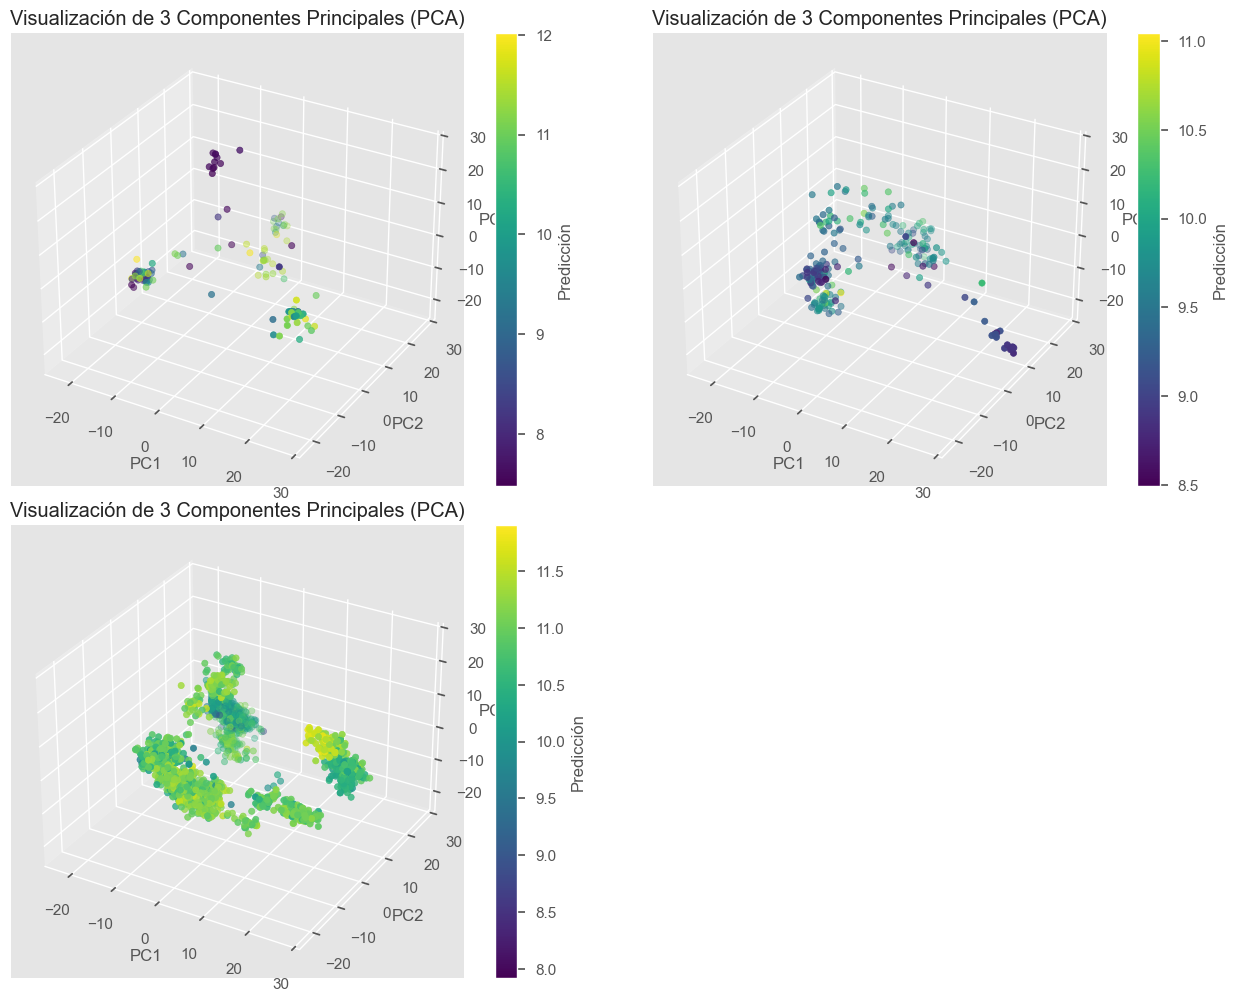

In [51]:
# Vista 3D de las nuevas secuencias generadas y sus propiedades

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Crear figura con dos subplots horizontales
fig = plt.figure(figsize=(13, 10))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax1.set_title('PCA 3D con Datos Conocidos')
ax2.set_title('PCA 3D con Datos Desconocidos')
ax3.set_title('PCA 3D con Datos Secuencias nuevas')

plot_pca_3d(    df_pca_conocidos,    pc_x='PC1',    pc_y='PC2',    pc_z='PC3',    color_by='pEC50',
                label='Predicción',    xlim=(-25, 30),    ylim=(-25, 30),    zlim=(-25, 30),    ax=ax1,
)

# Segundo subplot
plot_pca_3d(    df_pca_referencia,    pc_x='PC1',    pc_y='PC2',    pc_z='PC3',    color_by='pEC50',    label='Predicción',
                xlim=(-25, 30),    ylim=(-25, 30),    zlim=(-25, 30),    ax=ax2,)

plot_pca_3d(    df_pca_nuevas,    pc_x='PC1',    pc_y='PC2',    pc_z='PC3',    color_by='pEC50',    label='Predicción',
                xlim=(-25, 30),    ylim=(-25, 30),    zlim=(-25, 30),    ax=ax3,)


# Mostrar ambos
plt.tight_layout()
plt.show()


### Distribución de EC_50 entre los conjuntos de péptidos

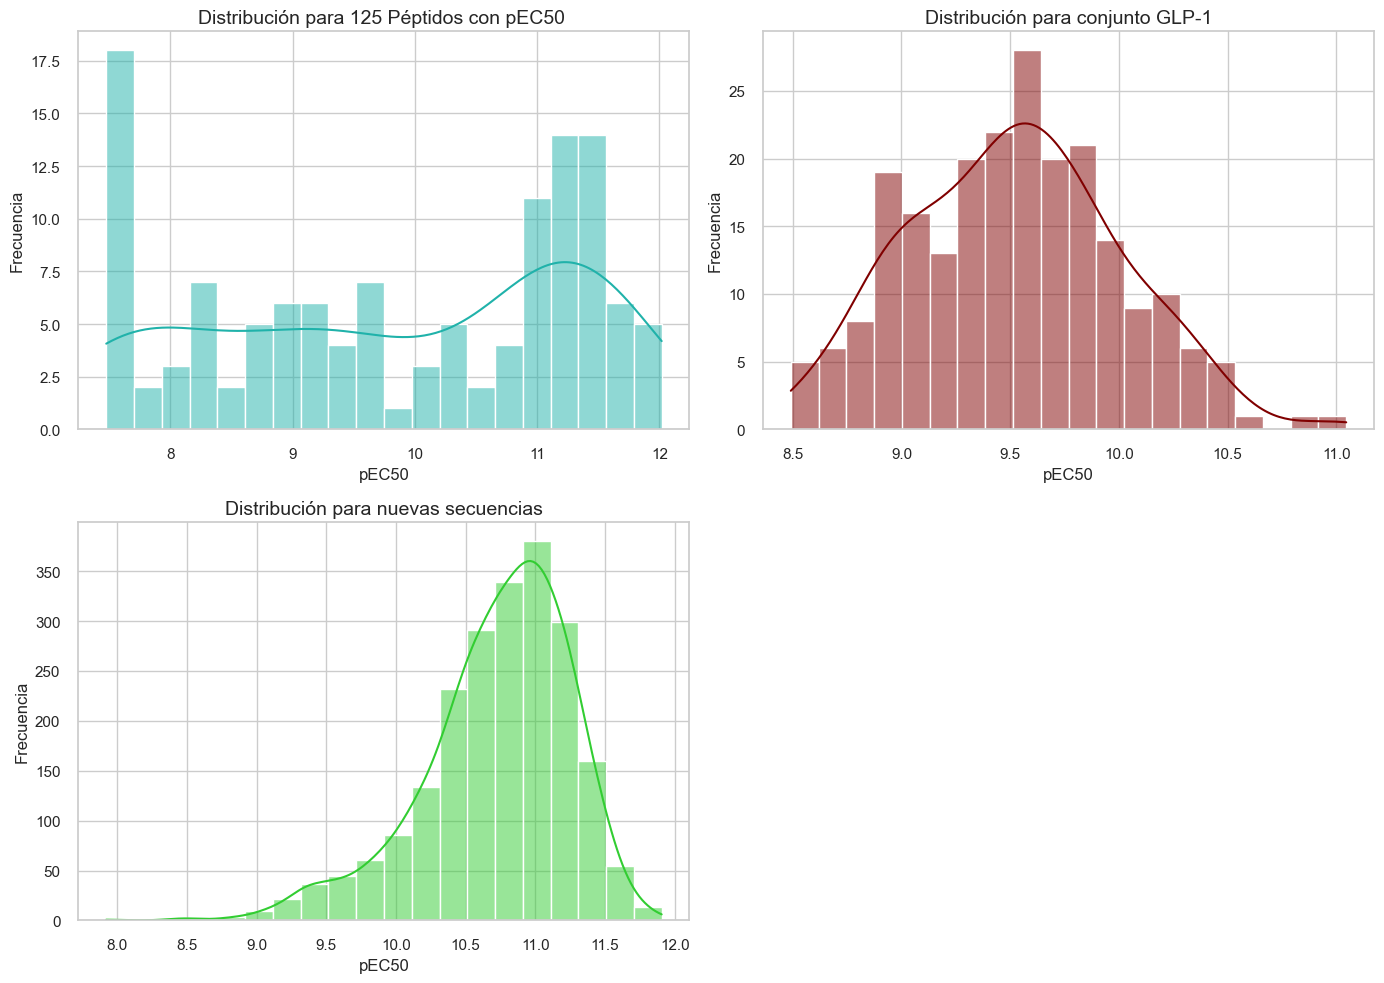

In [59]:
# Comparación de las distribuciones de pEC50 entre los tres dataframes
import seaborn as sns

# Configuración del estilo de la visualización
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# --- Gráfico 1 (Fila 1, Columna 1) ---
sns.histplot(df_125_conocidos['pEC50'], kde=True, bins=20, color='lightseagreen', ax=axes[0, 0])
axes[0, 0].set_title('Distribución para 125 Péptidos con pEC50 ', fontsize=14)
axes[0, 0].set_xlabel('pEC50', fontsize=12)
axes[0, 0].set_ylabel('Frecuencia', fontsize=12)

# --- Gráfico 2 (Fila 1, Columna 2) ---
sns.histplot(df_predicciones_glp1['pEC50'], kde=True, bins=20, color='maroon', ax=axes[0, 1])
axes[0, 1].set_title('Distribución para conjunto GLP-1', fontsize=14)
axes[0, 1].set_xlabel('pEC50', fontsize=12)
axes[0, 1].set_ylabel('Frecuencia', fontsize=12)

# --- Gráfico 3 (Fila 2, Columna 1) ---
sns.histplot(df_final_bert['pEC50'], kde=True, bins=20, color='limegreen', ax=axes[1, 0])
axes[1, 0].set_title('Distribución para nuevas secuencias', fontsize=14)
axes[1, 0].set_xlabel('pEC50', fontsize=12)
axes[1, 0].set_ylabel('Frecuencia', fontsize=12)

# --- Ocultar el subplot no utilizado (Fila 2, Columna 2) ---
axes[1, 1].axis('off')

# Ajustar el layout para que los títulos y etiquetas no se superpongan
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## Conclusiones y próximos pasos

## Conclusiones

En este cuarto avance, enfocado en la implementación de modelos alternativos, se logró un progreso significativo en la generación, evaluación y filtrado de péptidos con actividad agonista potencial sobre el receptor GLP-1 (GLP-1r). La integración de un modelo generativo (ProtXLNet) con un modelo predictivo de actividad biológica previamente generado (PyCaret) permitió producir un conjunto amplio de nuevas secuencias con actividad estimada comparable o superior a péptidos de referencia como el glucagón humano y fármacos aprobados como la liraglutida. De manera destacada, se identificaron múltiples secuencias con valores de pEC50 estimados en el rango de alta potencia (alrededor de 11.2–11.9), lo que confirma la efectividad del pipeline de generación y predicción aplicado.

Posteriormente, se incorporaron modelos alternativos basados en PeptideBERT para evaluar propiedades farmacéuticas clave como hemólisis (toxicidad), solubilidad y fouling (bioincrustación/no adherencia). Este análisis permitió aplicar un filtrado racional orientado a priorizar las secuencias con mayor viabilidad farmacológica. Como resultado, se generó un subconjunto de candidatos que no solo presentan alta actividad biológica predicha, sino que además exhiben baja probabilidad de toxicidad, buena solubilidad y baja tendencia a la bioincrustación. Este proceso permitió también aislar secuencias con propiedades no deseables (por ejemplo, alta hemólisis o baja solubilidad), aunque en ningun momento la hemolisis supero el 2% lo que hace a estos compuestos seguros.

El pipeline demostró ser eficiente para el descubrimiento temprano (in silico) de péptidos con potencial agonista de GLP-1 y perfil farmacológico favorable. Sin embargo, es importante reconocer que estos resultados siguen siendo predictivos y requieren validación experimental para confirmar su relevancia biológica. Asimismo, el modelo predictivo de actividad (pEC50) podría beneficiarse de la incorporación de un mayor número de datos experimentales para mejorar su capacidad de generalización y reducir posibles sesgos del conjunto de entrenamiento que actualmente es de solo 125 peptidos.

Entre las principales limitaciones observadas se encuentra tambien el desempeño del modelo generativo ProtXLNet, el cual mostró restricciones en la diversidad de las secuencias y tendencia a generar variantes con patrones repetitivos. Esto sugiere la necesidad de explorar arquitecturas más avanzadas, como ProtGPT2 u otros modelos generativos especializados en secuencias biológicas, que podrían mejorar la diversidad y calidad funcional de los péptidos generados. Asimismo, se propone en futuros avances integrar explícitamente las propiedades farmacéuticas predichas por PeptideBERT dentro del proceso generativo, con el fin de orientar la generación de secuencias hacia perfiles optimizados desde el inicio (generación condicionada).

Como próximos pasos, se plantea: 
1) migrar hacia un modelo generativo de mayor capacidad como ProtGPT2 para mejorar la diversidad estructural
2) implementar un proceso de screening iterativo que combine generación, predicción de actividad y evaluación farmacológica en ciclos sucesivos de optimización
3) extender el conjunto de datos experimentales disponibles para reforzar los modelos de predicción y reducir incertidumbre. 


## Referencias
* Elnaggar, A., Heinzinger, M., Dallago, C., Rehawi, G., Wang, Y., Jones, L., Gibbs, T., Feher, T., Angerer, C., Steinegger, M., Bhowmik, D., & Rost, B. (2021). ProtTrans: Toward Understanding the Language of Life Through Self-Supervised Learning. IEEE Transactions On Pattern Analysis And Machine Intelligence, 44(10), 7112-7127. https://doi.org/10.1109/tpami.2021.3095381

* Chen, Z., Wang, Q., & Zhang, J. (2023). Deep learning approaches for peptide design and drug discovery. Frontiers in Pharmacology, 14, 112345. https://doi.org/10.3389/fphar.2023.112345

* Elnaggar, A., Heinzinger, M., Dallago, C., Rehawi, G., Wang, Y., Jones, L., … Rost, B. (2022). ProtTrans: Toward understanding the language of life through self-supervised learning. IEEE Transactions on Pattern Analysis and Machine Intelligence, 44(10), 7112–7127. https://doi.org/10.1109/TPAMI.2021.3095381
* Grasso, G., Musso, N., & Rizzarelli, E. (2021). Toxicological assessment of peptide-based therapeutics: The role of hemolysis studies. Toxins, 13(4), 278. https://doi.org/10.3390/toxins13040278

* Li, H., Zhang, P., & Huang, D. (2022). Computational prediction of peptide solubility using deep learning methods. Bioinformatics Advances, 2(1), vbac012. https://doi.org/10.1093/bioadv/vbac012

* Madani, A., Krause, B., Greene, E. R., Subramanian, S., & Naik, N. (2023). Large language models in protein science: Applications and perspectives. Nature Machine Intelligence, 5, 433–447. https://doi.org/10.1038/s42256-023-00662-4

* White, A. D., Nowinski, A. K., & Keefe, A. J. (2019). Non-fouling surfaces: Design and applications. Annual Review of Chemical and Biomolecular Engineering, 10, 17–39. https://doi.org/10.1146/annurev-chembioeng-060718-030022

* Zhou, X., Chen, Y., & Liu, Y. (2023). AI-driven drug discovery: Integrating computational models with biological data. Nature Reviews Drug Discovery, 22(4), 271–289. https://doi.org/10.1038/s41573-023-00231-7

* Puszkarska, A. M., Taddese, B., Revell, J., Davies, G., Field, J., Hornigold, D. C., Buchanan, A., Vaughan, T. J., & Colwell, L. J. (2024). Machine learning designs new GCGR/GLP-1R dual agonists with enhanced biological potency. Nature Chemistry, 16(9), 1436-1444. https://doi.org/10.1038/s41557-024-01532-x

* Chou, K. (2001). Prediction of protein cellular attributes using pseudo‐amino acid composition. Proteins Structure Function And Bioinformatics, 43(3), 246-255. https://doi.org/10.1002/prot.1035

* Guntuboina, C., Das, A., Mollaei, P., Kim, S., & Farimani, A. B. (2023). PeptideBERT: A Language Model Based on Transformers for Peptide Property Prediction. The Journal Of Physical Chemistry Letters, 14(46), 10427-10434. https://doi.org/10.1021/acs.jpclett.3c02398